# Historico

In [1]:
import pandas as pd
import sys
import os

import plotly.graph_objects as go
import plotly.express as px


sys.path.append(os.path.abspath(os.path.join('../src')))  # Adjust as needed

from data_load import load_tables
from filtering import filter_labors_by_date, filter_labors_by_city

data_path = '../../data'

directorio_df, df_dist, cities_df = load_tables(data_path)

Genera el dataframe de un día y una ciudad

In [2]:
def vt_metrics(df: pd.DataFrame, day_str: str, workday_hours: float = 8.0):
    """
    Filtra labores cuyo labor_start_date y labor_end_date ocurren DURANTE el día day_str [inicio, fin),
    y calcula:
      - vt_count
      - alfred_ids (columna 'alfred' detectada con tolerancia)
      - num_drivers
      - labores_por_conductor = vt_count / num_drivers
      - trabajo_por_conductor_df: total_min, total_horas, utilización % y tiempo extra
      - resumen_df: incluye además la 'Utilización promedio conductores'
    """
    df = df.copy()

    # Validaciones mínimas
    for c in ['labor_start_date', 'labor_end_date', 'labor_category']:
        if c not in df.columns:
            raise KeyError(f"Falta la columna '{c}' en el DataFrame.")

    # Asegurar datetimes
    df['labor_start_date'] = pd.to_datetime(df['labor_start_date'], errors='coerce')
    df['labor_end_date']   = pd.to_datetime(df['labor_end_date'], errors='coerce')
    df = df.dropna(subset=['labor_start_date', 'labor_end_date'])

    # Ventana del día [start, end) preservando tz
    start = pd.to_datetime(day_str).normalize()
    tz = df['labor_start_date'].dt.tz
    if tz is not None and start.tzinfo is None:
        start = start.tz_localize(tz)
    end = start + pd.Timedelta(days=1)

    # Filtro: ambos timestamps dentro del día
    in_day = (
        df['labor_start_date'].between(start, end, inclusive='left') &
        df['labor_end_date'].between(start, end, inclusive='left')
    )
    df = df.loc[in_day].copy()

    # 1) Conteo VT
    vt_mask  = df['labor_category'].eq('VEHICLE_TRANSPORTATION')
    vt_count = int(vt_mask.sum())

    # 2) Detectar columna 'alfred' tolerante a variantes
    colmap = {c.lower(): c for c in df.columns}
    alfred_col = colmap.get('alfred')
    if alfred_col is None:
        for alias in ["alfred's", "assigned_driver", "driver", "conductor", "alfred_id"]:
            if alias in colmap:
                alfred_col = colmap[alias]
                break

    if alfred_col is None:
        alfred_ids = []
        num_drivers = 0
    else:
        alfred_ids = df[alfred_col].dropna().unique().tolist()
        try:
            alfred_ids = sorted(alfred_ids)
        except Exception:
            pass
        num_drivers = len(alfred_ids)

    # 3) Labores por conductor
    labores_por_conductor = (vt_count / num_drivers) if num_drivers > 0 else 0.0

    # 4) Tiempo total por conductor (solo VT) + tiempo extra
    trabajo_por_conductor_df = pd.DataFrame(
        columns=[alfred_col if alfred_col else 'driver',
                 'total_min', 'total_horas', 'utilizacion_%',
                 'tiempo_extra_min', 'tiempo_extra_horas']
    )
    if alfred_col is not None and vt_count > 0:
        df_vt = df.loc[vt_mask].copy()

        # Duración (min) por labor
        df_vt['duration_min'] = (
            (df_vt['labor_end_date'] - df_vt['labor_start_date']).dt.total_seconds() / 60
        )
        df_vt = df_vt.dropna(subset=['duration_min'])
        df_vt = df_vt[df_vt['duration_min'] >= 0]

        # Suma por conductor
        agg = (df_vt.dropna(subset=[alfred_col])
                    .groupby(alfred_col)['duration_min']
                    .sum()
                    .reset_index())

        if not agg.empty:
            agg.rename(columns={'duration_min': 'total_min'}, inplace=True)
            jornada_min = workday_hours * 60.0

            agg['total_horas']        = agg['total_min'] / 60.0
            agg['utilizacion_%']      = (agg['total_min'] / jornada_min * 100.0)
            agg['tiempo_extra_min']   = (agg['total_min'] - jornada_min).clip(lower=0)
            agg['tiempo_extra_horas'] = agg['tiempo_extra_min'] / 60.0

            # redondeos
            agg['total_min']          = agg['total_min'].round(1)
            agg['total_horas']        = agg['total_horas'].round(2)
            agg['utilizacion_%']      = agg['utilizacion_%'].round(1)
            agg['tiempo_extra_min']   = agg['tiempo_extra_min'].round(1)
            agg['tiempo_extra_horas'] = agg['tiempo_extra_horas'].round(2)

            trabajo_por_conductor_df = agg.sort_values('total_min', ascending=False).reset_index(drop=True)

    # 5) Resumen principal (agrega utilización promedio)
    if not trabajo_por_conductor_df.empty:
        util_prom = float(trabajo_por_conductor_df['utilizacion_%'].mean())
    else:
        util_prom = 0.0

    resumen_df = pd.DataFrame({
        "Métrica": [
            "Labores VEHICLE_TRANSPORTATION (día filtrado)",
            "Conductores únicos (alfred)",
            "Labores por conductor",
            "Utilización promedio conductores"
        ],
        "Valor": [
            vt_count,
            num_drivers,
            round(labores_por_conductor, 3),
            f"{util_prom:.1f}%"
        ]
    })

    return {
        "vt_count": vt_count,
        "alfred_col": alfred_col,
        "alfred_ids": alfred_ids,
        "num_drivers": num_drivers,
        "labores_por_conductor": labores_por_conductor,
        "resumen_df": resumen_df,
        "trabajo_por_conductor_df": trabajo_por_conductor_df,
        "filtered_df": df
    }


In [3]:
def plot_gantt_labors_by_driver(df: pd.DataFrame, day_str: str, driver_col: str | None = None,
                                min_row_height: int = 28, max_left_margin: int = 420,
                                tickfont_size: int = 11):
    """
    Gantt de labores por conductor para un día.
    - Ajusta automáticamente la altura de la figura y el margen izquierdo para que se vean todos los labels.
    - Rota las fechas del eje X para evitar solapes.
    """
    if df is None or df.empty:
        print("⚠️ DataFrame vacío.")
        return

    # Detectar columna conductor si no se pasa
    if driver_col is None:
        colmap = {c.lower(): c for c in df.columns}
        driver_col = (colmap.get('alfred') or colmap.get("alfred's") or
                      colmap.get('assigned_driver') or colmap.get('driver') or
                      colmap.get('conductor') or colmap.get('alfred_id'))
        if driver_col is None:
            raise KeyError("No se encontró columna de conductor (alfred / ALFRED'S / assigned_driver / driver / conductor / alfred_id).")

    # Asegurar datetimes
    dfp = df.copy()
    dfp['labor_start_date'] = pd.to_datetime(dfp['labor_start_date'], errors='coerce')
    dfp['labor_end_date']   = pd.to_datetime(dfp['labor_end_date'], errors='coerce')
    dfp = dfp.dropna(subset=['labor_start_date','labor_end_date'])

    # Ventana del día [start, end)
    start = pd.to_datetime(day_str).normalize()
    tz = dfp['labor_start_date'].dt.tz
    if tz is not None and start.tzinfo is None:
        start = start.tz_localize(tz)
    end = start + pd.Timedelta(days=1)

    # Filtro día, tiempos válidos y conductores no nulos
    in_day = (
        dfp['labor_start_date'].between(start, end, inclusive='left') &
        dfp['labor_end_date'].between(start, end, inclusive='left') &
        (dfp['labor_end_date'] > dfp['labor_start_date']) &
        (dfp[driver_col].notna())
    )
    dfp = dfp.loc[in_day].copy()
    if dfp.empty:
        print("⚠️ No hay labores con conductor para ese día.")
        return

    # Etiqueta Y = "<driver> (conteo)"
    counts = dfp.groupby(driver_col).size()
    dfp['driver_label'] = dfp[driver_col].map(lambda d: f"{d} ({int(counts.get(d,0))})")

    hover_cols = [c for c in [
        'labor_name','service_id','labor_id','labor_category',
        'labor_start_date','labor_end_date'
    ] if c in dfp.columns]

    # --- tamaño dinámico y margen izquierdo adaptativo ---
    unique_labels = dfp['driver_label'].unique().tolist()
    n_rows = len(unique_labels)
    # margen izquierdo ~ proporcional al largo máximo del label (capado)
    max_label_len = max(len(str(x)) for x in unique_labels)
    left_margin = min(60 + 7 * max_label_len, max_left_margin)
    # altura mínima y por fila
    height = max(320, int(min_row_height * (n_rows + 1)))

    fig = px.timeline(
        dfp.sort_values(['driver_label','labor_start_date']),
        x_start='labor_start_date', x_end='labor_end_date',
        y='driver_label',
        color='labor_category' if 'labor_category' in dfp.columns else None,
        hover_data=hover_cols
    )
    fig.update_yaxes(autorange='reversed', type='category', automargin=True, tickfont=dict(size=tickfont_size))
    fig.update_xaxes(tickangle=-45)
    fig.update_layout(
        title=f"Labores por conductor — {day_str}",
        margin=dict(l=left_margin, r=80, t=60, b=60),
        height=height,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    fig.show()


In [4]:
def collect_vt_metrics_range(
    df: pd.DataFrame,
    start_date: str,
    end_date: str,
    workday_hours: float = 8.0,
    city_code: int | None = 149,
    skip_weekends: bool = True
):
    """
    Recorre el rango [start_date, end_date] (inclusive), salta fines de semana si se indica,
    ejecuta vt_metrics por día y devuelve:
      - metrics_df: tabla con métricas por día
      - fig_metrics: (Labores por conductor vs Utilización promedio %)
      - fig_counts:  (N° conductores vs N° labores)
    """
    # Filtro por ciudad (si aplica)
    df_in = df.copy()
    if city_code is not None and 'city_code' in df_in.columns:
        df_in = df_in[df_in['city_code'] == city_code].copy()

    # Construir lista de días
    days = pd.date_range(start=start_date, end=end_date, freq='D')
    rows = []

    for d in days:
        if skip_weekends and d.weekday() >= 5:  # 5=sábado, 6=domingo
            continue
        day_str = d.strftime('%Y-%m-%d')

        m = vt_metrics(df_in, day_str=day_str, workday_hours=workday_hours)

        # Utilización promedio como número (no string)
        util_prom = float(m["trabajo_por_conductor_df"]["utilizacion_%"].mean()) \
                    if not m["trabajo_por_conductor_df"].empty else 0.0

        rows.append({
            "day": day_str,
            "vt_count": m["vt_count"],
            "num_drivers": m["num_drivers"],
            "labores_por_conductor": round(m["labores_por_conductor"], 3),
            "utilizacion_promedio_%": round(util_prom, 1)
        })

    metrics_df = pd.DataFrame(rows)
    if metrics_df.empty:
        print("⚠️ No hubo días hábiles en el rango (o no hay datos).")
        return metrics_df, None, None

    x = pd.to_datetime(metrics_df["day"])

    # ——— Gráfica 1: Labores/Conductor + Utilización promedio ———
    fig_metrics = go.Figure()
    fig_metrics.add_trace(go.Scatter(
        x=x, y=metrics_df["labores_por_conductor"],
        mode="lines+markers", name="Labores por conductor"
    ))
    fig_metrics.add_trace(go.Scatter(
        x=x, y=metrics_df["utilizacion_promedio_%"],
        mode="lines+markers", name="Utilización promedio (%)",
        yaxis="y2"
    ))
    fig_metrics.update_layout(
        title=f"Métricas diarias — {start_date} a {end_date}" + (" (sin fines de semana)" if skip_weekends else ""),
        xaxis_title="Día",
        yaxis=dict(title="Labores por conductor"),
        yaxis2=dict(title="Utilización promedio (%)", overlaying="y", side="right", range=[0, 100]),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    # ——— Gráfica 2: N° Conductores y N° Labores ———
    fig_counts = go.Figure()
    fig_counts.add_trace(go.Bar(
        x=x, y=metrics_df["num_drivers"], name="N° Conductores"
    ))
    fig_counts.add_trace(go.Bar(
        x=x, y=metrics_df["vt_count"], name="N° Labores VT"
    ))
    fig_counts.update_layout(
        title=f"Conductores y Labores por día — {start_date} a {end_date}",
        xaxis_title="Día",
        yaxis_title="Conteo",
        barmode="group",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    return metrics_df, fig_metrics, fig_counts


In [5]:
# =========================
# 1) Helper día-a-día (SOLO conductores del día)
# =========================

def show_day_report_dayonly(
    df_full: pd.DataFrame,
    metrics_df: pd.DataFrame,
    *,
    idx: int | None = None,          # el índice dentro de metrics_df (día hábil)
    day_str: str | None = None,      # o la fecha explícita 'YYYY-MM-DD'
    workday_hours: float = 8.0,
    city_code: int | None = 149,
    only_vt: bool = False            # True → Gantt solo de VEHICLE_TRANSPORTATION
):
    """
    Muestra MÉTRICAS + GANTT solo con los conductores que trabajaron ese día.
    Usa vt_metrics para filtrar al día y toma el alfred_col detectado allí.
    """
    if (idx is None) and (day_str is None):
        raise ValueError("Debes pasar 'idx' o 'day_str'.")

    # Resolver day_str desde metrics_df si viene por idx
    if day_str is None:
        if idx < 0 or idx >= len(metrics_df):
            raise IndexError(f"idx fuera de rango: 0..{len(metrics_df)-1}")
        day_str = str(metrics_df.loc[idx, "day"])
    else:
        day_str = pd.to_datetime(day_str).strftime("%Y-%m-%d")

    # Filtrar ciudad si aplica
    dfx = df_full.copy()
    if city_code is not None and "city_code" in dfx.columns:
        dfx = dfx[dfx["city_code"] == city_code].copy()

    # Métricas del día (ya filtra a [day, day+1) y elimina conductores sin labores ese día)
    m_day = vt_metrics(dfx, day_str=day_str, workday_hours=workday_hours)

    # Data del día y columna de conductor detectada
    df_day = m_day["filtered_df"].copy()
    driver_col = m_day["alfred_col"]
    if driver_col is None:
        raise KeyError("No se encontró columna de conductor (alfred / ALFRED'S / assigned_driver / driver / conductor / alfred_id).")

    # Lista de conductores que SÍ trabajaron ese día
    drivers_present = (
        df_day[driver_col].dropna().unique().tolist()
        if not df_day.empty else []
    )

    # Asegurar que solo mostramos métricas de esos conductores (por si acaso)
    trabajo_df = m_day["trabajo_por_conductor_df"]
    if not trabajo_df.empty:
        trabajo_df = trabajo_df[trabajo_df[driver_col].isin(drivers_present)].reset_index(drop=True)

    # Mostrar métricas del día
    print(f"Reporte del día: {day_str}")
    display(m_day["resumen_df"])
    display(trabajo_df)

    # Preparar DF para el Gantt (opcionalmente solo VT) y SOLO drivers del día
    df_plot = df_day.copy()
    if only_vt and "labor_category" in df_plot.columns:
        df_plot = df_plot[df_plot["labor_category"] == "VEHICLE_TRANSPORTATION"]
    df_plot = df_plot[df_plot[driver_col].isin(drivers_present)]

    # Gantt del día (solo conductores presentes)
    plot_gantt_labors_by_driver(df_plot, day_str=day_str, driver_col=driver_col)

    return {
        "day_str": day_str,
        "drivers_present": drivers_present,
        "metrics": m_day,
        "trabajo_por_conductor_df": trabajo_df
    }


# =========================
# 2) EJECUCIÓN COMPLETA
# =========================
# (a) Rango y métricas del rango
start_date = "2025-07-01"
end_date   = "2025-07-28"

metrics_df, fig_metrics, fig_counts = collect_vt_metrics_range(
    df=df_dist,           # tu dataframe completo
    start_date=start_date,
    end_date=end_date,
    workday_hours=8,
    city_code=149,        # Bogotá
    skip_weekends=True
)

display(metrics_df)
if fig_metrics: fig_metrics.show()  # Labores/Conductor + Utilización promedio
if fig_counts:  fig_counts.show()   # N° Conductores + N° Labores



#    Opción 2: por fecha exacta dentro del rango
day_report = show_day_report_dayonly(
    df_full=df_dist,
    metrics_df=metrics_df,
    day_str="2025-07-15",
    workday_hours=8,
    city_code=149,
    only_vt=True
)


,day,vt_count,num_drivers,labores_por_conductor,utilizacion_promedio_%
0,2025-07-01,107,33,3.242,60.6
1,2025-07-02,138,36,3.833,73.4
2,2025-07-03,112,34,3.294,65.0
3,2025-07-04,134,34,3.941,72.7
4,2025-07-07,131,36,3.639,69.7
5,2025-07-08,135,36,3.750,77.6
6,2025-07-09,126,34,3.706,73.0
7,2025-07-10,138,31,4.452,81.1
8,2025-07-11,120,37,3.243,68.1
9,2025-07-14,133,35,3.800,66.6


Reporte del día: 2025-07-15


,Métrica,Valor
0,Labores VEHICLE_TRANSPORTATION (día filtrado),113
1,Conductores únicos (alfred),33
2,Labores por conductor,3.424
3,Utilización promedio conductores,66.5%


,alfred,total_min,total_horas,utilizacion_%,tiempo_extra_min,tiempo_extra_horas
0,3214.0,562.8,9.38,117.2,82.8,1.38
1,20111.0,514.0,8.57,107.1,34.0,0.57
2,72680.0,511.0,8.52,106.5,31.0,0.52
3,11714.0,508.9,8.48,106.0,28.9,0.48
4,5455.0,471.0,7.85,98.1,0.0,0.00
5,4554.0,445.0,7.42,92.7,0.0,0.00
6,6229.0,440.6,7.34,91.8,0.0,0.00
7,211.0,423.0,7.05,88.1,0.0,0.00
8,26834.0,413.0,6.88,86.0,0.0,0.00
9,10451.0,384.9,6.42,80.2,0.0,0.00


# Guardar en pickle

In [ ]:
# # ==============================================
# # 1) Generar el archivo de distancias con 'manhattan'
# # ==============================================
# import pickle
# import pandas as pd
# import math
# from itertools import combinations

# # ——————————————————————————————
# # Reuso tu función `parse_point` y `distance`
# # ——————————————————————————————
# def parse_point(point_str):
#     if pd.isna(point_str):
#         return None, None
#     s = point_str.strip()
#     if not s.startswith("POINT"):
#         return None, None
#     lon, lat = map(float, s.lstrip('POINT').strip(' ()').split())
#     return lat, lon

# OSRM_URL = "http://router.project-osrm.org/route/v1/driving/"
# def distance(p1, p2, method='manhattan', timeout=5):
#     lat1, lon1 = parse_point(p1)
#     lat2, lon2 = parse_point(p2)
#     if None in (lat1, lon1, lat2, lon2):
#         return float('nan')
#     if method == 'haversine':
#         φ1, φ2 = map(math.radians, (lat1, lat2))
#         dφ = math.radians(lat2 - lat1)
#         dλ = math.radians(lon2 - lon1)
#         a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
#         return 2 * 6371 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
#     if method == 'osrm':
#         coords = f"{lon1},{lat1};{lon2},{lat2}"
#         try:
#             import requests
#             r = requests.get(OSRM_URL + coords + "?overview=false", timeout=timeout)
#             r.raise_for_status()
#             return r.json()['routes'][0]['distance'] / 1000
#         except:
#             return distance(p1, p2, method='haversine')
#     # Manhattan aproximada
#     KM_PER_DEG_LAT = 111.32
#     mean_lat = math.radians((lat1 + lat2) / 2)
#     dlat = abs(lat1 - lat2) * KM_PER_DEG_LAT
#     dlon = abs(lon1 - lon2) * KM_PER_DEG_LAT * math.cos(mean_lat)
#     return dlat + dlon

# # ——————————————————————————————
# # Recolectar todos los puntos
# # ——————————————————————————————
# puntos = set()

# # posiciones iniciales de conductores en Bogotá
# for _, d in directorio_df[directorio_df['city']=='BOGOTA'].iterrows():
#     if pd.isna(d['latitud']) or pd.isna(d['longitud']):
#         continue
#     puntos.add(f"POINT ({d['longitud']} {d['latitud']})")

# # puntos de los labors
# for col in ['address_point', 'start_address_point', 'end_address_point']:
#     pts = df_cleaned[col].dropna().unique()
#     puntos.update(pts)

# puntos = list(puntos)

# # ——————————————————————————————
# # Calcular distancias con método 'manhattan'
# # ——————————————————————————————
# dist_dict = {}
# for p1, p2 in combinations(puntos, 2):
#     d = distance(p1, p2, method='osrm')
#     dist_dict[(p1, p2)] = d
#     dist_dict[(p2, p1)] = d
# for p in puntos:
#     dist_dict[(p, p)] = 0.0

# # ——————————————————————————————
# # Guardar en pickle
# # ——————————————————————————————
# with open('distances.pkl', 'wb') as f:
#     pickle.dump(dist_dict, f)

# print(f"✔ Se calcularon distancias para {len(puntos)} puntos y se guardó 'distances.pkl'")


In [2]:
# df_dist.to_pickle('df_dist.pkl')
# df_dist.to_csv("Datos/Procesados/df_dist.csv", index=False)

In [3]:
# import os
# import pickle
# import pandas as pd
# import math
# import requests
# import random
# from datetime import timedelta
# from filtros_df import filter_labors_by_city

# # ——————————————————————————————
# # Parámetros y cargas base
# # ——————————————————————————————
# SEED = 10
# random.seed(SEED)

# directorio_df = pd.read_csv("Datos/Procesados/directorio_df.csv")
# df_dist        = pd.read_pickle("df_dist.pkl")
# with open("distances.pkl", "rb") as f:
#     DIST_DICT = pickle.load(f)

# def parse_point(s):
#     if pd.isna(s) or not s.strip().startswith("POINT"):
#         return None, None
#     lon, lat = map(float, s.lstrip("POINT").strip(" ()").split())
#     return lat, lon

# OSRM_URL = "http://router.project-osrm.org/route/v1/driving/"
# def distance(p1, p2, method="haversine", timeout=5):
#     if method=="precalced":
#         return DIST_DICT.get((p1,p2), float("nan"))
#     lat1, lon1 = parse_point(p1)
#     lat2, lon2 = parse_point(p2)
#     if None in (lat1,lon1,lat2,lon2):
#         return float("nan")
#     if method=="haversine":
#         φ1, φ2 = map(math.radians,(lat1,lat2))
#         dφ = math.radians(lat2-lat1)
#         dλ = math.radians(lon2-lon1)
#         a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
#         return 2*6371*math.atan2(math.sqrt(a),math.sqrt(1-a))
#     if method=="osrm":
#         coords = f"{lon1},{lat1};{lon2},{lat2}"
#         try:
#             r = requests.get(OSRM_URL+coords+"?overview=false",timeout=timeout)
#             r.raise_for_status()
#             return r.json()['routes'][0]['distance']/1000
#         except:
#             return distance(p1,p2,method='haversine')
#     KM_PER_DEG_LAT = 111.32
#     mean_lat = math.radians((lat1+lat2)/2)
#     dlat = abs(lat1-lat2)*KM_PER_DEG_LAT
#     dlon = abs(lon1-lon2)*KM_PER_DEG_LAT*math.cos(mean_lat)
#     return dlat+dlon

# def process_group(grp):
#     # Sólo transportes
#     A_idx = list(grp.index[grp['labor_category']=='VEHICLE_TRANSPORTATION'])
#     if not A_idx:
#         return grp.iloc[0:0]
#     # Sólo shops válidos
#     B_idx = [i for i in grp.index[grp['labor_category']!='VEHICLE_TRANSPORTATION']
#              if pd.notna(grp.at[i,'shop']) and pd.notna(grp.at[i,'address_point'])]
#     if not B_idx:
#         return grp.iloc[0:0]

#     # Seleccionar primer transporte
#     inits = [i for i in A_idx if grp.at[i,'labor_name']=='Alfred Initial Transport']
#     firstA = inits[0] if inits else A_idx[0]
#     A_remain = [i for i in A_idx if i!=firstA]

#     # Ordenar shops por distancia al punto inicial
#     start_pt = grp['start_address_point'].iloc[0]
#     dist_map = {
#         i: (float('inf') if pd.isna((d:=distance(start_pt, grp.at[i,'address_point']))) else d)
#         for i in B_idx
#     }
#     max_B = len(A_idx) - 1
#     B_sorted = sorted(B_idx, key=lambda i: dist_map[i])[:max_B]

#     # A adicionales en orden de hora
#     A_remain_sorted = sorted(A_remain, key=lambda i: grp.at[i,'labor_start_date'])
#     needed_A = [firstA] + A_remain_sorted[:len(B_sorted)]

#     # Intercalar A y B
#     final = []
#     for j, b in enumerate(B_sorted):
#         final += [needed_A[j], b]
#     final.append(needed_A[-1])

#     return grp.loc[final]

# # Filtrar Bogotá
# df_bogota = filter_labors_by_city(df_dist, 149)

# # Carpeta de salida
# out_dir = "processed_by_day"
# os.makedirs(out_dir, exist_ok=True)

# # Para crear DataFrame vacío con las columnas adecuadas
# all_cols = list(df_bogota.columns) + ["map_start_point","map_end_point"]

# summary = []
# for day in sorted(df_bogota["schedule_date"].dt.date.unique()):
#     df_day = (
#         df_bogota[df_bogota["schedule_date"].dt.date == day]
#           .query("state_service!='CANCELED'")
#           .sort_values(["service_id","labor_start_date"])
#           .reset_index(drop=True)
#     )

#     # services_map_df diario
#     rows = []
#     for svc, grp in df_day.groupby("service_id", sort=False):
#         idxs = grp.index.tolist(); n = len(idxs)
#         for i, idx in enumerate(idxs):
#             r = grp.loc[idx]
#             if n==1:
#                 sp, ep = r["start_address_point"], r["end_address_point"]
#             else:
#                 if r["labor_category"]=="VEHICLE_TRANSPORTATION":
#                     sp = r["start_address_point"]
#                     ep = grp.iloc[i+1]["end_address_point"] if i<n-1 else r["end_address_point"]
#                 else:
#                     sp = ep = r["address_point"]
#             rows.append({
#                 "service_id": svc,
#                 "labor_id":   r["labor_id"],
#                 "map_start_point": sp,
#                 "map_end_point":   ep
#             })

#     services_map_df = pd.DataFrame(rows,
#         columns=["service_id","labor_id","map_start_point","map_end_point"])
#     if not services_map_df.empty:
#         services_map_df["labor_id"] = services_map_df["labor_id"].astype(df_day["labor_id"].dtype)

#     # plantillas limpias
#     cleaned = []
#     for svc, grp in df_day.groupby("service_id", sort=False):
#         pg = process_group(grp)
#         if not pg.empty:
#             cleaned.append(pg)

#     if cleaned:
#         df_cleaned = (
#             pd.concat(cleaned, ignore_index=True)
#               .merge(services_map_df, on=["service_id","labor_id"], how="left")
#         )
#     else:
#         df_cleaned = pd.DataFrame(columns=all_cols)

#     # guardar
#     fn = os.path.join(out_dir, f"cleaned_{day}.pkl")
#     df_cleaned.to_pickle(fn)
#     summary.append({"date": day, "n_labors": len(df_cleaned), "file": fn})

# # Resumen
# summary_df = pd.DataFrame(summary).sort_values("n_labors", ascending=False).reset_index(drop=True)
# print("Días con más labores:\n", summary_df[["date","n_labors"]].head())

# # opcional guardar CSV
# summary_df.to_csv(os.path.join(out_dir, "daily_summary.csv"), index=False)


In [4]:
# summary_df.to_csv(os.path.join(out_dir, "daily_summary.csv"), index=False)

In [5]:
# summary_df = pd.read_csv("processed_by_day/daily_summary.csv")
# summary_df

# ITERACIONES

#### Limpiar datos por día

In [6]:
# ── BLOQUE 1: PREPROCESAMIENTO ESTÁTICO Y GUARDADO ─────────────────────────────────

import pickle
import pandas as pd
import math
import requests
import random
from datetime import datetime, timedelta
# from filtering import filter_labors_by_date, filter_labors_by_city

# — Parámetros —————————————————————————————————————————————————————————————
ITERATIONS              = 5
ALPHA                   = 1
SEED                    = 10
DISTANCE_METHOD         = 'Manhattan'
alfred_speed            = 30   # km/h para conductor hacia primer punto
vehicle_transport_speed = 40   # km/h para transporte de vehículo
tiempo_previo           = 30   # minutos antes del schedule_date
tiempo_gracia           = 15
tiempo_alistar          = 15
tiempo_other            = 30
tiempo_finalizacion     = 15

random.seed(SEED)

# — Cargar distancias precalculadas ——————————————————————————————————————————
with open('distances.pkl', 'rb') as f:
    DIST_DICT = pickle.load(f)

# — Cargar datos base ———————————————————————————————————————————————————————
# directorio_df = pd.read_csv("Datos/Procesados/directorio_df.csv")
# df_dist       = pd.read_pickle("df_dist.pkl") # ya se carga con las funciones

# — 0) Filtrado y mix automático de días en base_day ———————————————————————————
start_date = "2023-01-02"
end_date   = "2023-01-03"

# Filtrado por ciudad (Bogotá=149) y por rango de fechas
df_bogota = filter_labors_by_city(df_dist, '149')
df_dia    = filter_labors_by_date(df_bogota, start_date=start_date, end_date=end_date)
df_dia    = df_dia.query("state_service!='CANCELED'") \
                 .sort_values(['service_id','labor_start_date']) \
                 .reset_index(drop=True)

# — 0.2) Remapeo fechas a base_day ————————————————————————————————————————
base_day = pd.to_datetime(start_date).date()
def remap_to_base(dt):
    if pd.isna(dt): return dt
    delta = (base_day - dt.date()).days
    return dt + timedelta(days=delta)

for c in ['schedule_date','labor_start_date','labor_end_date']:
    df_dia[c] = df_dia[c].apply(remap_to_base)

# — 0.3) Construir services_map_df ————————————————————————————————————————
map_src = df_dia[[
    'service_id','labor_id','labor_category',
    'start_address_point','end_address_point','address_point',
    'labor_start_date'
]].sort_values(['service_id','labor_start_date']).reset_index(drop=True)

rows = []
for svc, grp in map_src.groupby('service_id', sort=False):
    n    = len(grp)
    idxs = grp.index.tolist()
    for i, idx in enumerate(idxs):
        r = grp.loc[idx]
        if n == 1:
            sp, ep = r['start_address_point'], r['end_address_point']
        else:
            if r['labor_category']=='VEHICLE_TRANSPORTATION':
                sp = r['start_address_point']
                ep = grp.iloc[i+1]['end_address_point'] if i<n-1 else r['end_address_point']
            else:
                sp = ep = r['address_point']
        rows.append({
            'service_id':      svc,
            'labor_id':        r['labor_id'],
            'map_start_point': sp,
            'map_end_point':   ep
        })
services_map_df = pd.DataFrame(rows)
services_map_df['labor_id'] = services_map_df['labor_id'].astype(df_dia['labor_id'].dtype)

# — 1) Funciones auxiliares: parse_point, distance —————————————————————————————
def parse_point(s):
    if pd.isna(s) or not s.strip().startswith("POINT"): return None, None
    lon, lat = map(float, s.lstrip('POINT').strip(' ()').split())
    return lat, lon

OSRM_URL = "http://router.project-osrm.org/route/v1/driving/"
def distance(p1, p2, method='haversine', timeout=5):
    if method=='precalced':
        return DIST_DICT.get((p1,p2), float('nan'))
    lat1, lon1 = parse_point(p1)
    lat2, lon2 = parse_point(p2)
    if None in (lat1,lon1,lat2,lon2): return float('nan')
    if method=='haversine':
        φ1,φ2 = map(math.radians,(lat1,lat2))
        dφ    = math.radians(lat2-lat1)
        dλ    = math.radians(lon2-lon1)
        a     = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
        return 2*6371*math.atan2(math.sqrt(a), math.sqrt(1-a))
    if method=='osrm':
        coords = f"{lon1},{lat1};{lon2},{lat2}"
        try:
            r = requests.get(OSRM_URL+coords+"?overview=false", timeout=timeout)
            r.raise_for_status()
            return r.json()['routes'][0]['distance']/1000
        except:
            return distance(p1,p2,method='haversine')
    # Manhattan
    KM_PER_DEG_LAT = 111.32
    mean_lat = math.radians((lat1+lat2)/2)
    dlat = abs(lat1-lat2)*KM_PER_DEG_LAT
    dlon = abs(lon1-lon2)*KM_PER_DEG_LAT*math.cos(mean_lat)
    return dlat + dlon

# — 2) process_group (con corrección para A_idx vacío) —————————————————————————
def process_group(grp):
    # si sólo tiene 1 labor, la dejamos si es VEHICLE_TRANSPORTATION
    if len(grp)==1:
        return grp if grp.iloc[0]['labor_category']=='VEHICLE_TRANSPORTATION' else grp.iloc[0:0]

    A_idx = list(grp.index[grp['labor_category']=='VEHICLE_TRANSPORTATION'])
    # nueva línea: si no hay ninguna VEHICLE_TRANSPORTATION, descartamos el servicio
    if not A_idx:
        return grp.iloc[0:0]

    B_idx = [i for i in grp.index[grp['labor_category']!='VEHICLE_TRANSPORTATION']
             if pd.notna(grp.at[i,'shop']) and pd.notna(grp.at[i,'address_point'])]
    if not B_idx:
        return grp.iloc[0:0]

    inits   = [i for i in A_idx if grp.at[i,'labor_name']=='Alfred Initial Transport']
    firstA  = inits[0] if inits else A_idx[0]
    A_rem   = [i for i in A_idx if i!=firstA]

    start_pt = grp['start_address_point'].iloc[0]
    dist_map = {i: distance(start_pt, grp.at[i,'address_point']) for i in B_idx}
    B_sorted = sorted(B_idx, key=lambda i: dist_map[i])[:len(A_idx)-1]

    A_rem_sorted = sorted(A_rem, key=lambda i: grp.at[i,'labor_start_date'])
    needed_A     = [firstA] + A_rem_sorted[:len(B_sorted)]

    final = []
    for j, b in enumerate(B_sorted):
        final += [needed_A[j], b]
    final.append(needed_A[-1])

    return grp.loc[final]

# — 3) Construir df_cleaned_template y merge con map points ——————————————————————
cleaned = []
for svc, grp in df_dia.groupby('service_id', sort=False):
    pg = process_group(grp)
    if not pg.empty:
        cleaned.append(pg)
df_cleaned_template = (
    pd.concat(cleaned, ignore_index=True)
      .merge(services_map_df, on=['service_id','labor_id'], how='left')
)

# — 4) avg_times_map de df_dist —————————————————————————————————————————————
df_temp = (
    df_dist
      .dropna(subset=['labor_start_date','labor_end_date'])
      .assign(duration_td=lambda d: d['labor_end_date']-d['labor_start_date'])
)
df_temp = df_temp[df_temp['duration_td']<=pd.Timedelta(days=1)]
df_temp['duration_min'] = df_temp['duration_td'].dt.total_seconds()/60
avg_times_map = df_temp.groupby('labor_name')['duration_min'].mean().to_dict()

# — 5) Guardar plantilla para BLOQUE 2 ——————————————————————————————————————
df_cleaned_template.to_pickle('cleaned_static_template.pkl')
print("✅ BLOQUE 1 completado: plantilla estática guardada en 'cleaned_static_template.pkl'")




df_cleaned_template['day'] = df_cleaned_template['schedule_date'].dt.date

# 3) Agrupar por día y contar número de labors
daily_counts = (
    df_cleaned_template
      .groupby('day')
      .size()
      .reset_index(name='num_labors')
      .sort_values('num_labors', ascending=False)
      .reset_index(drop=True)
)

# 4) Mostrar resultados
print("Días con más labors (después de procesar Bloque 1):")
print(daily_counts)

✅ BLOQUE 1 completado: plantilla estática guardada en 'cleaned_static_template.pkl'
Días con más labors (después de procesar Bloque 1):
          day  num_labors
0  2023-01-02          33


In [7]:
def compute_indicators(df_cleaned, df_moves):
    """
    Calcula y retorna:
      - indicators: diccionario con los valores crudos
      - ind_df: DataFrame listo para imprimir o exportar
    """
    # 1) Precondición
    if df_moves.empty:
        return {}, pd.DataFrame()

    # Cálculo de cada indicador
    num_labors   = len(df_cleaned)
    num_drivers  = len(init_drivers())

    free_min     = df_moves.loc[df_moves['labor_category']=='FREE_TIME','duration_min'].sum()
    total_min    = df_moves['duration_min'].sum()
    pct_free     = 100 * free_min / total_min if total_min > 0 else 0

    svc_fail     = (
        df_cleaned[df_cleaned['labor_category']=='VEHICLE_TRANSPORTATION']
          .groupby('service_id')['assigned_driver']
          .apply(lambda x: x.isna().all())
    )
    failed       = svc_fail.sum()
    total_s      = df_cleaned['service_id'].nunique()
    pct_failed   = 100 * failed / total_s if total_s > 0 else 0

    # Llegadas tarde
    n_late = 0
    total_tardy_norm = 0.0
    vt_df = df_cleaned[(df_cleaned['labor_category']=='VEHICLE_TRANSPORTATION') & df_cleaned['actual_start'].notna()]
    if not vt_df.empty:
        firsts_df      = vt_df.sort_values('schedule_date').groupby('service_id').first()
        late_deadlines = firsts_df['schedule_date'] + timedelta(minutes=tiempo_gracia)
        raw_late       = firsts_df['actual_start'] - late_deadlines
        n_late         = (raw_late > timedelta(0)).sum()
        capped_late    = raw_late.clip(lower=timedelta(0))
        total_tardy_sec= capped_late.dt.total_seconds().sum()
        assigned_s     = total_s - failed
        if assigned_s > 0:
            total_tardy_norm = total_tardy_sec / (tiempo_gracia * 60 * assigned_s)

    # Promedio servicios por conductor
    assigned_drivers_df = df_cleaned[df_cleaned['assigned_driver'].notna()]
    avg_per_driver = (
        assigned_drivers_df.groupby('assigned_driver')['service_id']
        .nunique().mean()
        if not assigned_drivers_df.empty else 0
    )

    # Indicador ponderado (pesos iniciales)
    obj_weighted = pct_free*0 + pct_failed*0 + total_tardy_norm*0 + avg_per_driver*0.5

    indicators = {
        'num_labors':         num_labors,
        'num_drivers':        num_drivers,
        'pct_free':           pct_free,
        'pct_failed':         pct_failed,
        'n_late':             int(n_late),
        'total_tardy_norm':   total_tardy_norm,
        'avg_per_driver':     avg_per_driver,
        'obj_weighted':       obj_weighted
    }

    # DataFrame para mostrar
    ind_df = pd.DataFrame({
        'Indicador': [
            'N° Labores', 'N° Conductores Disponibles', '% Tiempo Libre',
            '% Fallidas', 'N° Llegadas Tarde', '% Tardanza (norm.)',
            'Prom. Servicios x Conductor', 'Obj. Ponderado'
        ],
        'Valor': [
            indicators['num_labors'],
            indicators['num_drivers'],
            f"{indicators['pct_free']:.1f}%",
            f"{indicators['pct_failed']:.1f}%",
            indicators['n_late'],
            f"{indicators['total_tardy_norm']*100:.1f}%",
            f"{indicators['avg_per_driver']:.2f}",
            f"{indicators['obj_weighted']:.2f}"
        ]
    })

    return indicators, ind_df


def plot_results(df_cleaned, df_moves):
    """
    Genera los dos Gantt (conductores y servicios) y los muestra,
    incluyendo órdenes fallidas, marcadores de llegadas tarde,
    y el conteo de labors por conductor en el eje y.
    """
    if df_moves.empty:
        print(f"⚠️ No hay tareas para el día {day_str}")
        return

    # 1) Preparo df para plot
    df_plot = df_moves[df_moves['assigned_driver'].notna()].copy()
    df_plot['assigned_driver'] = df_plot['assigned_driver'].astype(str)

    # 2) Calculo conteo de labors (excluyo FREE_TIME y DRIVER_MOVE)
    labor_counts = (
        df_plot[~df_plot['labor_category'].isin(['FREE_TIME','DRIVER_MOVE'])]
          .groupby('assigned_driver').size()
          .to_dict()
    )

    # 3) Construyo mapping de etiquetas
    #    e.g. "Roberto Amaya" → "Roberto Amaya (12)"
    y_labels = {
        drv: f"{drv} ({labor_counts.get(drv,0)})"
        for drv in df_plot['assigned_driver'].unique()
    }

    # 4) Gantt de conductores
    fig = px.timeline(
        df_plot,
        x_start="actual_start", x_end="actual_end",
        y="assigned_driver", color="labor_category",
        color_discrete_map={'FREE_TIME':'gray', 'DRIVER_MOVE':'lightblue'},
        hover_data={
            "labor_name":    True,
            "service_id":    True,
            "labor_id":      True,
            "schedule_date": True,
            "duration_min":  True,
            "start_point":   True,
            "end_point":     True
        }
    )
    # obtengo el orden original
    cats = fig.layout.yaxis.categoryarray or list(dict.fromkeys(df_plot['assigned_driver']))
    # aplico nuevas etiquetas
    ticktext = [y_labels.get(cat, cat) for cat in cats]
    fig.update_yaxes(
        autorange="reversed",
        type='category',
        categoryorder='array',
        categoryarray=cats,
        ticktext=ticktext,
        tickvals=cats
    )
    fig.update_layout(
        height=max(600, len(cats)*30),
        title=f"Driver Tasks Over Time ({day_str})"
    )

    # 5) Órdenes fallidas
    fails = df_cleaned[
        (df_cleaned['labor_category']=='VEHICLE_TRANSPORTATION') &
        (df_cleaned['assigned_driver'].isna())
    ]
    if not fails.empty:
        x_seg, y_seg = [], []
        for sched in fails['schedule_date']:
            x_seg += [sched, sched, None]
            y_seg += [cats[0], cats[-1], None]
        fig.add_trace(go.Scatter(
            x=x_seg, y=y_seg, mode='lines',
            line=dict(color='red', dash='dash'),
            name='Fallido', legendgroup='Fallido'
        ))
        fig.add_trace(go.Scatter(
            x=fails['schedule_date'],
            y=[cats[0]]*len(fails),
            mode='markers',
            marker=dict(symbol='line-ns-open', color='red', size=12),
            name='Fallido', legendgroup='Fallido',
            customdata=fails[['service_id','labor_id','map_start_point']].values,
            hovertemplate=(
                "Fallido<br>Service: %{customdata[0]}<br>"
                "Labor: %{customdata[1]}<br>"
                "Ubicación: %{customdata[2]}<extra></extra>"
            )
        ))

    # 6) Llegadas tarde
    late_tasks = (
        df_cleaned[df_cleaned['labor_category']=='VEHICLE_TRANSPORTATION']
          .sort_values('schedule_date')
          .groupby('service_id').first()
          .reset_index()
    )
    if not late_tasks.empty:
        late_tasks['late_dead'] = late_tasks['schedule_date'] + timedelta(minutes=tiempo_gracia)
        late = late_tasks[
            late_tasks['assigned_driver'].notna() &
            (late_tasks['actual_start'] > late_tasks['late_dead'])
        ].copy()
        if not late.empty:
            late['late_minutes'] = (
                (late['actual_start'] - late['late_dead'])
                .dt.total_seconds() / 60
            ).round(1)
            fig.add_trace(go.Scatter(
                x=late['actual_start'],
                y=late['assigned_driver'].astype(str),
                mode='markers',
                marker=dict(symbol='x', size=12, color='black'),
                name='Llegada Tarde', legendgroup='Llegada Tarde',
                customdata=late[['service_id','labor_id','late_minutes']].values,
                hovertemplate=(
                    "Llegada Tarde<br>Service: %{customdata[0]}<br>"
                    "Labor: %{customdata[1]}<br>"
                    "Retraso: %{customdata[2]} min<extra></extra>"
                )
            ))
    fig.show()

    # 7) Gantt de servicios con detalle (igual que antes)
    df_cleaned_plot = df_cleaned.dropna(subset=['actual_start','actual_end'])
    if not df_cleaned_plot.empty:
        df_cleaned_plot['service_id_str'] = df_cleaned_plot['service_id'].astype(str)
        df_cleaned_plot['driver_label']   = df_cleaned_plot['assigned_driver'].fillna('on site').astype(str)
        fig2 = px.timeline(
            df_cleaned_plot.sort_values(['service_id_str','actual_start']),
            x_start="actual_start", x_end="actual_end",
            y="service_id_str", color="labor_category",
            title=f"Detalle de labors por Servicio ({day_str})",
            hover_data=["driver_label","labor_name"]
        )
        fig2.update_yaxes(autorange="reversed", type='category')
        fig2.update_layout(
            height=max(600, len(df_cleaned_plot['service_id_str'].unique()))
        )
        fig2.show()



In [10]:
import pickle
import pandas as pd
import math
import random
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
import requests

# — Parámetros & Seed —————————————————————————————————————————————————————————
ITERATIONS              = 100
ALPHA                   = 1
SEED                    = 10
DISTANCE_METHOD         = 'Manhattan'
alfred_speed            = 30
vehicle_transport_speed = 40
tiempo_previo           = 30
tiempo_gracia           = 15
tiempo_alistar          = 15
tiempo_other            = 30
tiempo_finalizacion     = 15

random.seed(SEED)

# — Cargar datos preprocesados y bases necesarias —————————————————————————————
# Cargar el DataFrame original
directorio_df = pd.read_csv(f"{data_path}/data_pre/directorio_df.csv")
def remove_drivers(df, driver_names):
    """
    Devuelve una copia de df sin las filas donde la columna "ALFRED'S" coincida con cualquiera de los nombres en driver_names.
    """
    if isinstance(driver_names, str):
        driver_names = [driver_names]
    filtered_df = df[~df["ALFRED'S"].isin(driver_names)].copy()
    return filtered_df

nombres_a_quitar = ["Manuel Romero", "Jorge Cortes Rojas", "Orlando Jacinto"]
directorio_df = remove_drivers(directorio_df, nombres_a_quitar)


"""
    Días de prueba
"""
# day_str             = "2023-01-30"  # dia de prueba a tope
# day_str             = "2024-05-30"  # dia medio
day_str             = "2024-10-21"  # dia bajo
# day_str             = "2024-02-03"  # dia muy bajo



template_path       = f"{data_path}/data_clean/templates/cleaned_static_template_{day_str}.pkl"
df_cleaned_template = pd.read_pickle(template_path)
with open('distances.pkl','rb') as f:
    DIST_DICT = pickle.load(f)

# Filtrar labores programadas para las 7:00 AM o antes
print(f"INFO: Labores iniciales: {len(df_cleaned_template)}")
df_cleaned_template = df_cleaned_template[df_cleaned_template['schedule_date'].dt.hour > 7].copy()
print(f"INFO: Después de filtrar por horario, quedan {len(df_cleaned_template)} labores.")

# Filtrar ubicaciones inválidas 'POINT (0 0)' <<<
initial_rows = len(df_cleaned_template)
df_cleaned_template = df_cleaned_template[
    (df_cleaned_template['map_start_point'] != 'POINT (0 0)') &
    (df_cleaned_template['map_end_point'] != 'POINT (0 0)')
].copy()
filtered_count = initial_rows - len(df_cleaned_template)
if filtered_count > 0:
    print(f"INFO: Se han filtrado {filtered_count} labores con ubicación 'POINT (0 0)'. Quedan {len(df_cleaned_template)} labores.")


# — Recompute avg_times_map —————————————————————————————————————————————————
df_temp = (
    df_dist
      .dropna(subset=['labor_start_date','labor_end_date'])
      .assign(duration_td=lambda d: d['labor_end_date'] - d['labor_start_date'])
)
df_temp = df_temp[df_temp['duration_td'] <= pd.Timedelta(days=1)]
df_temp['duration_min'] = df_temp['duration_td'].dt.total_seconds() / 60
avg_times_map = df_temp.groupby('labor_name')['duration_min'].mean().to_dict()

# — Auxiliares parse_point, distance, select, init_drivers —————————————————————
def parse_point(s):
    if pd.isna(s) or not s.strip().startswith("POINT"):
        return None, None
    lon, lat = map(float, s.lstrip('POINT').strip(' ()').split())
    return lat, lon

OSRM_URL = "http://router.project-osrm.org/route/v1/driving/"
def distance(p1, p2, method='haversine', timeout=5):
    if method=='precalced':
        return DIST_DICT.get((p1,p2), float('nan'))
    lat1, lon1 = parse_point(p1)
    lat2, lon2 = parse_point(p2)
    if None in (lat1,lon1,lat2,lon2): return float('nan')
    if method=='haversine':
        φ1,φ2 = map(math.radians,(lat1,lat2))
        dφ    = math.radians(lat2-lat1)
        dλ    = math.radians(lon2-lon1)
        a     = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
        return 2*6371*math.atan2(math.sqrt(a), math.sqrt(1-a))
    if method=='osrm':
        coords = f"{lon1},{lat1};{lon2},{lat2}"
        try:
            r = requests.get(OSRM_URL+coords+"?overview=false", timeout=timeout)
            r.raise_for_status()
            return r.json()['routes'][0]['distance']/1000
        except:
            return distance(p1,p2,method='haversine')
    # Manhattan
    KM_PER_DEG_LAT = 111.32
    mean_lat = math.radians((lat1+lat2)/2)
    dlat = abs(lat1-lat2)*KM_PER_DEG_LAT
    dlon = abs(lon1-lon2)*KM_PER_DEG_LAT*math.cos(mean_lat)
    return dlat + dlon


def select_from_candidates(cands, alpha):
    if not cands: return None
    costs = [c['arrival'].timestamp() for c in cands]
    if len(costs) == 1:
        return cands[0]
    min_cost, max_cost = min(costs), max(costs)
    if min_cost == max_cost:
        return random.choice(cands)
    thr   = max_cost - alpha * (max_cost - min_cost)
    RCL   = [c for c,cost in zip(cands,costs) if cost<=thr]
    return random.choice(RCL) if RCL else cands[costs.index(min_cost)]


def init_drivers():
    if df_cleaned_template.empty:
        return []
    tz    = df_cleaned_template['schedule_date'].dt.tz
    first = df_cleaned_template['schedule_date'].dt.date.min()
    out   = []
    df_dir = directorio_df[directorio_df['city']=='BOGOTA']
    for _, d in df_dir.iterrows():
        if pd.isna(d['latitud']): continue
        ws    = datetime.strptime(d['start_time'], '%H:%M:%S').time()
        avail = datetime.combine(first, ws)
        out.append({
            'name':       d["ALFRED'S"],
            'position':   f"POINT ({d['longitud']} {d['latitud']})",
            'available':  pd.Timestamp(avail).tz_localize(tz),
            'work_start': ws
        })
    return out

# — run_iteration (LÓGICA DE SIMULACIÓN) —————————————————————————————————————
def run_iteration_chronological(alpha):
    if df_cleaned_template.empty:
        return pd.DataFrame(), pd.DataFrame()

    dfc = df_cleaned_template.copy().reset_index(drop=True)
    drivers = init_drivers()
    
    df_sorted = dfc.sort_values('schedule_date').reset_index()

    assigned = [pd.NA] * len(dfc)
    starts = [pd.NaT] * len(dfc)
    ends = [pd.NaT] * len(dfc)

    service_end_times = {}

    for _, row in df_sorted.iterrows():
        original_idx = row['index'] 
        service_id = row['service_id']

        if service_end_times.get(service_id) is pd.NaT:
            continue

        prev_end = service_end_times.get(service_id)
        cat, sched = row['labor_category'], row['schedule_date']

        if cat == 'VEHICLE_TRANSPORTATION':
            early = prev_end or (sched - timedelta(minutes=tiempo_previo))
            late  = (prev_end + timedelta(minutes=tiempo_gracia)) if prev_end else (sched + timedelta(minutes=tiempo_gracia))
            
            cands = []
            for drv in drivers:
                av = drv['available']
                if av.time() < drv['work_start']:
                    av = pd.Timestamp(datetime.combine(av.date(), drv['work_start']), tz=av.tz)
                
                dkm = distance(drv['position'], row['map_start_point'], method=DISTANCE_METHOD)
                arr = av + timedelta(minutes=(0 if math.isnan(dkm) else dkm/alfred_speed*60))
                
                if arr <= late:
                    cands.append({'drv': drv, 'arrival': arr})
            
            pick = select_from_candidates(cands, alpha)

            if not pick:
                service_end_times[service_id] = pd.NaT
            else:
                drv = pick['drv']
                astart = max(pick['arrival'], early)
                d2 = distance(row['map_start_point'], row['map_end_point'], method=DISTANCE_METHOD)
                
                is_last_in_service = not dfc[(dfc['service_id'] == service_id) & (dfc['schedule_date'] > sched)].empty
                dur = tiempo_alistar + (0 if math.isnan(d2) else d2/vehicle_transport_speed*60) \
                      + (tiempo_finalizacion if not is_last_in_service else 0)
                aend = astart + timedelta(minutes=dur)

                drv['available'], drv['position'] = aend, row['map_end_point']
                assigned[original_idx] = drv['name']
                starts[original_idx] = astart
                ends[original_idx] = aend
                service_end_times[service_id] = aend
        else:
            astart = prev_end or sched
            aend = astart + timedelta(minutes=avg_times_map.get(row['labor_name'], tiempo_other))
            starts[original_idx] = astart
            ends[original_idx] = aend
            service_end_times[service_id] = aend

    dfc['assigned_driver'] = assigned
    dfc['actual_start']    = pd.to_datetime(starts)
    dfc['actual_end']      = pd.to_datetime(ends)

    records = []
    tz = dfc['schedule_date'].dt.tz
    if not tz and not dfc['actual_start'].dropna().empty:
        tz = dfc['actual_start'].dropna().iloc[0].tz

    valid_dates = dfc['schedule_date'].dropna().dt.date
    first = pd.to_datetime(day_str).date() if valid_dates.empty else valid_dates.min()

    driver_pos, driver_end = {}, {}
    df_dir_bog = directorio_df[directorio_df['city']=='BOGOTA']
    for _, d in df_dir_bog.iterrows():
        if pd.isna(d['latitud']): continue
        name = d["ALFRED'S"]
        driver_pos[name] = f"POINT ({d['longitud']} {d['latitud']})"
        st = datetime.combine(first, datetime.strptime(d['start_time'],'%H:%M:%S').time())
        driver_end[name] = pd.Timestamp(st, tz=tz)

    for _, row in dfc.dropna(subset=['actual_start']).sort_values('actual_start').iterrows():
        drv = row['assigned_driver']
        if pd.notna(drv) and row['labor_category']=='VEHICLE_TRANSPORTATION':
            prev_e, prev_p = driver_end[drv], driver_pos[drv]
            if row['actual_start'] > prev_e:
                dkm = distance(prev_p, row['map_start_point'], method=DISTANCE_METHOD)
                t_m = timedelta(minutes=(0 if math.isnan(dkm) else dkm/alfred_speed*60))
                depart = max(prev_e, row['actual_start'] - t_m)
                if depart > prev_e:
                    records.append({'service_id': row['service_id'], 'labor_id': f"{int(row['labor_id'])}_free", 'labor_name': 'FREE_TIME', 'labor_category': 'FREE_TIME', 'assigned_driver': drv, 'schedule_date': row['schedule_date'], 'actual_start': prev_e, 'actual_end': depart, 'start_point': prev_p, 'end_point': prev_p})
                records.append({'service_id': row['service_id'], 'labor_id': f"{int(row['labor_id'])}_move", 'labor_name': 'DRIVER_MOVE', 'labor_category': 'DRIVER_MOVE', 'assigned_driver': drv, 'schedule_date': row['schedule_date'], 'actual_start': depart, 'actual_end': row['actual_start'], 'start_point': prev_p, 'end_point': row['map_start_point']})
        
        records.append({'service_id': row['service_id'], 'labor_id': int(row['labor_id']), 'labor_name': row['labor_name'], 'labor_category': row['labor_category'], 'assigned_driver': row['assigned_driver'], 'schedule_date': row['schedule_date'], 'actual_start': row['actual_start'], 'actual_end': row['actual_end'], 'start_point': row['map_start_point'], 'end_point': row['map_end_point']})
        
        if pd.notna(drv) and pd.notna(row['actual_end']):
            driver_end[drv] = row['actual_end']
            driver_pos[drv] = row['map_end_point']

    df_moves = pd.DataFrame(records)
    if not df_moves.empty:
        df_moves['actual_start'] = pd.to_datetime(df_moves['actual_start'])
        df_moves['actual_end'] = pd.to_datetime(df_moves['actual_end'])
        df_moves['duration_min'] = ((df_moves['actual_end'] - df_moves['actual_start']).dt.total_seconds() / 60).round(1)

    return dfc, df_moves


# — Ejecutar —————————————————————————————————————————————————————————
df_cleaned, df_moves = run_iteration_chronological(ALPHA)


indicators, ind_df = compute_indicators(df_cleaned, df_moves)
print(ind_df)
plot_results(df_cleaned, df_moves)


INFO: Labores iniciales: 82
INFO: Después de filtrar por horario, quedan 77 labores.
INFO: Se han filtrado 2 labores con ubicación 'POINT (0 0)'. Quedan 75 labores.
                     Indicador  Valor
0                   N° Labores     75
1   N° Conductores Disponibles     17
2               % Tiempo Libre  50.9%
3                   % Fallidas   0.0%
4            N° Llegadas Tarde      4
5           % Tardanza (norm.)  28.4%
6  Prom. Servicios x Conductor   3.65
7               Obj. Ponderado   1.82


In [9]:
df_cleaned

,service_id,labor_id,labor_type,labor_name,labor_category,labor_price,labor_created_at,labor_start_date,labor_end_date,alfred,...,address_point,address_name,start_to_point,point_to_end,start_to_end,map_start_point,map_end_point,assigned_driver,actual_start,actual_end
0,170421,259818.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,44530.0,2024-10-15 09:23:52.606000-05:00,2024-10-21 08:57:00-05:00,2024-10-21 09:41:00-05:00,4006.0,...,NaN,NaN,NaN,NaN,3.400519,POINT (-74.0794651 4.6431175),POINT (-74.1099777 4.6463301),Yeisson Beltran Garzon,2024-10-21 08:30:00-05:00,2024-10-21 09:05:36.882108-05:00
1,170497,259904.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,35000.0,2024-10-15 12:33:38.678000-05:00,2024-10-21 07:06:00-05:00,2024-10-21 08:24:00-05:00,14671.0,...,NaN,NaN,NaN,NaN,0.000000,POINT (-74.0431538 4.7058175),POINT (-74.0431538 4.7058175),Ancisar Echavarría,2024-10-21 07:30:00-05:00,2024-10-21 08:00:00-05:00
2,170497,263705.0,6.0,General Mechanics,GENERAL_MECHANICS,783930.0,2024-10-23 13:29:50.195000-05:00,2024-10-21 13:00:00-05:00,2024-10-21 13:00:00-05:00,NaN,...,POINT (-74.0597209 4.7143523),AP Motors,2.066733,2.066733,0.000000,POINT (-74.0597209 4.7143523),POINT (-74.0597209 4.7143523),<NA>,2024-10-21 08:00:00-05:00,2024-10-21 14:19:20.051390-05:00
3,170497,263706.0,2.0,Alfred Transport,VEHICLE_TRANSPORTATION,35000.0,2024-10-23 13:29:50.247000-05:00,2024-10-21 15:17:00-05:00,2024-10-21 18:06:00-05:00,5409.0,...,NaN,NaN,NaN,NaN,0.000000,POINT (-74.0431538 4.7058175),POINT (-74.0431538 4.7058175),Alberto Mora,2024-10-21 14:19:20.051390-05:00,2024-10-21 14:49:20.051390-05:00
4,170573,259982.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,35000.0,2024-10-15 16:03:32.050000-05:00,2024-10-21 08:29:00-05:00,2024-10-21 10:01:00-05:00,5366.0,...,NaN,NaN,NaN,NaN,0.000000,POINT (-74.08403810000001 4.7079054),POINT (-74.08403810000001 4.7079054),José Ricardo Pérez Alarcón,2024-10-21 08:09:59.430790-05:00,2024-10-21 08:39:59.430790-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,173110,262647.0,2.0,Alfred Transport,VEHICLE_TRANSPORTATION,35000.0,2024-10-21 12:07:11.797000-05:00,2024-10-21 17:22:00-05:00,2024-10-21 18:59:00-05:00,11988.0,...,NaN,NaN,NaN,NaN,0.000000,POINT (-74.05526569999999 4.856347999999999),POINT (-74.05526569999999 4.856347999999999),Alberto Mora,2024-10-21 16:46:40.704115-05:00,2024-10-21 17:16:40.704115-05:00
71,173124,262661.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,56430.0,2024-10-21 13:03:15.210000-05:00,2024-10-21 13:11:00-05:00,2024-10-21 17:38:00-05:00,3214.0,...,NaN,NaN,NaN,NaN,8.408195,POINT (-74.065413 4.759951),POINT (-74.14064019999999 4.750069499999999),Omar Fonseca,2024-10-21 15:00:00-05:00,2024-10-21 15:44:10.093049-05:00
72,173132,262669.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,44530.0,2024-10-21 13:22:22.990000-05:00,2024-10-21 13:23:00-05:00,2024-10-21 14:06:00-05:00,211.0,...,NaN,NaN,NaN,NaN,6.534437,POINT (-74.07450039999999 4.6948373),POINT (-74.04551409999999 4.746012299999999),Julio Cesar Parra,2024-10-21 13:00:00-05:00,2024-10-21 13:43:22.135002-05:00
73,173133,262670.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,44530.0,2024-10-21 13:26:13.776000-05:00,2024-10-21 13:30:00-05:00,2024-10-21 16:17:00-05:00,6229.0,...,NaN,NaN,NaN,NaN,13.309983,POINT (-74.1068427 4.6475984),POINT (-74.065413 4.759951),Jhon Zambrano,2024-10-21 14:00:00-05:00,2024-10-21 14:55:39.316126-05:00


In [10]:
df_moves

,service_id,labor_id,labor_name,labor_category,assigned_driver,schedule_date,actual_start,actual_end,start_point,end_point,duration_min
0,170497,259904_free,FREE_TIME,FREE_TIME,Ancisar Echavarría,2024-10-21 08:00:00-05:00,2024-10-21 07:00:00-05:00,2024-10-21 07:15:22.032408-05:00,POINT (-74.0877144 4.7271318),POINT (-74.0877144 4.7271318),15.4
1,170497,259904_move,DRIVER_MOVE,DRIVER_MOVE,Ancisar Echavarría,2024-10-21 08:00:00-05:00,2024-10-21 07:15:22.032408-05:00,2024-10-21 07:30:00-05:00,POINT (-74.0877144 4.7271318),POINT (-74.0431538 4.7058175),14.6
2,170497,259904,Alfred Initial Transport,VEHICLE_TRANSPORTATION,Ancisar Echavarría,2024-10-21 08:00:00-05:00,2024-10-21 07:30:00-05:00,2024-10-21 08:00:00-05:00,POINT (-74.0431538 4.7058175),POINT (-74.0431538 4.7058175),30.0
3,172037,261508_free,FREE_TIME,FREE_TIME,Iván Darío Pinta,2024-10-21 08:00:00-05:00,2024-10-21 07:00:00-05:00,2024-10-21 07:20:43.429988-05:00,POINT (-74.0199021 4.666103),POINT (-74.0199021 4.666103),20.7
4,172037,261508_move,DRIVER_MOVE,DRIVER_MOVE,Iván Darío Pinta,2024-10-21 08:00:00-05:00,2024-10-21 07:20:43.429988-05:00,2024-10-21 07:30:00-05:00,POINT (-74.0199021 4.666103),POINT (-74.03414339999999 4.6935736),9.3
...,...,...,...,...,...,...,...,...,...,...,...
188,173110,262647_move,DRIVER_MOVE,DRIVER_MOVE,Alberto Mora,2024-10-21 16:00:00-05:00,2024-10-21 16:10:28.624858-05:00,2024-10-21 16:46:40.704115-05:00,POINT (-74.0431538 4.7058175),POINT (-74.05526569999999 4.856347999999999),36.2
189,173110,262647,Alfred Transport,VEHICLE_TRANSPORTATION,Alberto Mora,2024-10-21 16:00:00-05:00,2024-10-21 16:46:40.704115-05:00,2024-10-21 17:16:40.704115-05:00,POINT (-74.05526569999999 4.856347999999999),POINT (-74.05526569999999 4.856347999999999),30.0
190,173026,262547_free,FREE_TIME,FREE_TIME,Ancisar Echavarría,2024-10-21 16:00:00-05:00,2024-10-21 15:08:58.616133-05:00,2024-10-21 16:33:26.610080-05:00,POINT (-74.0731931 4.660674),POINT (-74.0731931 4.660674),84.5
191,173026,262547_move,DRIVER_MOVE,DRIVER_MOVE,Ancisar Echavarría,2024-10-21 16:00:00-05:00,2024-10-21 16:33:26.610080-05:00,2024-10-21 16:46:40.704115-05:00,POINT (-74.0731931 4.660674),POINT (-74.0693964 4.7163353),13.2


In [11]:
df_dia 

,service_id,labor_id,labor_type,labor_name,labor_category,labor_price,labor_created_at,labor_start_date,labor_end_date,alfred,...,start_address_point,end_address_id,end_address_point,city,address_id,address_point,address_name,start_to_point,point_to_end,start_to_end
0,77038,135213.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,30000.0,2022-12-20 12:43:12.462000-05:00,2023-01-02 06:29:00-05:00,2023-01-02 09:28:00-05:00,13174.0,...,POINT (-74.05567789999999 4.6767276),41155.0,POINT (-74.1929755 4.786795),149.0,<NA>,NaN,NaN,<NA>,<NA>,19.526406
1,77780,136735.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,35000.0,2022-12-26 09:10:37.934000-05:00,2023-01-02 06:04:00-05:00,2023-01-02 07:31:00-05:00,11988.0,...,POINT (-74.0103498 4.9327366),29156.0,POINT (-74.03727236805345 4.878226952715764),149.0,<NA>,NaN,NaN,<NA>,<NA>,6.755333
2,78058,137380.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,27800.0,2022-12-27 17:09:56.534000-05:00,2023-01-02 05:44:00-05:00,2023-01-02 07:20:00-05:00,26783.0,...,POINT (-74.03088439999999 4.7138151),3325.0,POINT (-74.06386971473694 4.709362767211348),149.0,<NA>,NaN,NaN,<NA>,<NA>,3.688779
3,78237,137688.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,35000.0,2022-12-28 13:39:05.027000-05:00,2023-01-02 06:46:00-05:00,2023-01-02 07:26:00-05:00,5832.0,...,POINT (-74.08188679999999 4.6946549),34502.0,POINT (-74.08188679999999 4.6946549),149.0,<NA>,NaN,NaN,<NA>,<NA>,0.0
4,78237,137689.0,3.0,Wash and Polish,WASH_AND_POLISH,20900.0,2022-12-28 13:39:05.224000-05:00,2023-01-02 07:26:00-05:00,2023-01-02 08:43:00-05:00,NaN,...,POINT (-74.08188679999999 4.6946549),34502.0,POINT (-74.08188679999999 4.6946549),149.0,2898,POINT (-74.0482171 4.7095537),SPV 127 Car Wash,4.082542,4.082542,0.0
5,78237,137690.0,2.0,Alfred Transport,VEHICLE_TRANSPORTATION,35000.0,2022-12-28 13:39:05.398000-05:00,2023-01-02 08:43:00-05:00,2023-01-02 09:29:00-05:00,5832.0,...,POINT (-74.08188679999999 4.6946549),34502.0,POINT (-74.08188679999999 4.6946549),149.0,<NA>,NaN,NaN,<NA>,<NA>,0.0
6,78240,137693.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,20000.0,2022-12-28 14:13:18.945000-05:00,2023-01-02 05:08:00-05:00,2023-01-02 07:05:00-05:00,10500.0,...,POINT (-74.0524153 4.758526299999999),48509.0,POINT (-74.089187 4.614638999999999),149.0,<NA>,NaN,NaN,<NA>,<NA>,16.510363
7,78284,137777.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,35000.0,2022-12-28 20:22:21.917000-05:00,2023-01-02 07:52:00-05:00,2023-01-02 08:04:00-05:00,14662.0,...,POINT (-74.0563122 4.698653),33218.0,POINT (-74.0563122 4.698653),149.0,<NA>,NaN,NaN,<NA>,<NA>,0.0
8,78284,137778.0,3.0,Wash and Polish,WASH_AND_POLISH,20900.0,2022-12-28 20:22:22.090000-05:00,2023-01-02 08:04:00-05:00,2023-01-02 09:26:00-05:00,NaN,...,POINT (-74.0563122 4.698653),33218.0,POINT (-74.0563122 4.698653),149.0,2898,POINT (-74.0482171 4.7095537),SPV 127 Car Wash,1.507974,1.507974,0.0
9,78284,137779.0,2.0,Alfred Transport,VEHICLE_TRANSPORTATION,35000.0,2022-12-28 20:22:22.252000-05:00,2023-01-02 09:26:00-05:00,2023-01-02 09:42:00-05:00,14662.0,...,POINT (-74.0563122 4.698653),33218.0,POINT (-74.0563122 4.698653),149.0,<NA>,NaN,NaN,<NA>,<NA>,0.0


In [12]:
df_cleaned_template


,service_id,labor_id,labor_type,labor_name,labor_category,labor_price,labor_created_at,labor_start_date,labor_end_date,alfred,...,city,service_mode,address_id,address_point,address_name,start_to_point,point_to_end,start_to_end,map_start_point,map_end_point
0,170421,259818.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,44530.0,2024-10-15 09:23:52.606000-05:00,2024-10-21 08:57:00-05:00,2024-10-21 09:41:00-05:00,4006.0,...,149.0,WITH_DRIVER,NaN,NaN,NaN,NaN,NaN,3.400519,POINT (-74.0794651 4.6431175),POINT (-74.1099777 4.6463301)
1,170497,259904.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,35000.0,2024-10-15 12:33:38.678000-05:00,2024-10-21 07:06:00-05:00,2024-10-21 08:24:00-05:00,14671.0,...,149.0,WITH_DRIVER,NaN,NaN,NaN,NaN,NaN,0.000000,POINT (-74.0431538 4.7058175),POINT (-74.0431538 4.7058175)
2,170497,263705.0,6.0,General Mechanics,GENERAL_MECHANICS,783930.0,2024-10-23 13:29:50.195000-05:00,2024-10-21 13:00:00-05:00,2024-10-21 13:00:00-05:00,NaN,...,149.0,WITH_DRIVER,66918.0,POINT (-74.0597209 4.7143523),AP Motors,2.066733,2.066733,0.000000,POINT (-74.0597209 4.7143523),POINT (-74.0597209 4.7143523)
3,170497,263706.0,2.0,Alfred Transport,VEHICLE_TRANSPORTATION,35000.0,2024-10-23 13:29:50.247000-05:00,2024-10-21 15:17:00-05:00,2024-10-21 18:06:00-05:00,5409.0,...,149.0,WITH_DRIVER,NaN,NaN,NaN,NaN,NaN,0.000000,POINT (-74.0431538 4.7058175),POINT (-74.0431538 4.7058175)
4,170573,259982.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,35000.0,2024-10-15 16:03:32.050000-05:00,2024-10-21 08:29:00-05:00,2024-10-21 10:01:00-05:00,5366.0,...,149.0,WITH_DRIVER,NaN,NaN,NaN,NaN,NaN,0.000000,POINT (-74.08403810000001 4.7079054),POINT (-74.08403810000001 4.7079054)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,173110,262647.0,2.0,Alfred Transport,VEHICLE_TRANSPORTATION,35000.0,2024-10-21 12:07:11.797000-05:00,2024-10-21 17:22:00-05:00,2024-10-21 18:59:00-05:00,11988.0,...,149.0,WITH_DRIVER,NaN,NaN,NaN,NaN,NaN,0.000000,POINT (-74.05526569999999 4.856347999999999),POINT (-74.05526569999999 4.856347999999999)
78,173124,262661.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,56430.0,2024-10-21 13:03:15.210000-05:00,2024-10-21 13:11:00-05:00,2024-10-21 17:38:00-05:00,3214.0,...,149.0,WITH_DRIVER,NaN,NaN,NaN,NaN,NaN,8.408195,POINT (-74.065413 4.759951),POINT (-74.14064019999999 4.750069499999999)
79,173132,262669.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,44530.0,2024-10-21 13:22:22.990000-05:00,2024-10-21 13:23:00-05:00,2024-10-21 14:06:00-05:00,211.0,...,149.0,WITH_DRIVER,NaN,NaN,NaN,NaN,NaN,6.534437,POINT (-74.07450039999999 4.6948373),POINT (-74.04551409999999 4.746012299999999)
80,173133,262670.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,44530.0,2024-10-21 13:26:13.776000-05:00,2024-10-21 13:30:00-05:00,2024-10-21 16:17:00-05:00,6229.0,...,149.0,WITH_DRIVER,NaN,NaN,NaN,NaN,NaN,13.309983,POINT (-74.1068427 4.6475984),POINT (-74.065413 4.759951)


In [13]:
# ————————————————————————————————————————————————————————————————
# Actualizar un día con TIEMPOS REALES usando assigned_driver simulado
# Bogotá (city_code = 149) • df_moves = FREE_TIME + labores reales
# ————————————————————————————————————————————————————————————————
import pandas as pd
from datetime import timedelta

def actualize_from_df_dist_one_day(
    df_cleaned_sim: pd.DataFrame,
    df_dist: pd.DataFrame,
    day_str: str,
    city_code: int = 149
):
    """
    Devuelve:
        df_cleaned_act: columnas mínimas con tiempos reales (clipeados al día)
        df_moves_act:   FREE_TIME + labores reales por driver (sin DRIVER_MOVE)
    Empareja por ['service_id','labor_id'].
    """
    # — asegurar fechas reales —
    dfh = df_dist.copy()
    for c in ['labor_start_date', 'labor_end_date']:
        dfh[c] = pd.to_datetime(dfh[c], errors='coerce')
    dfh = dfh.dropna(subset=['labor_start_date', 'labor_end_date'])

    # — filtro ciudad si existe —
    if 'city_code' in dfh.columns:
        dfh = dfh[dfh['city_code'] == city_code].copy()

    # — ventana del día (overlap-aware) —
    start = pd.Timestamp(day_str).normalize()
    tz = dfh['labor_start_date'].dt.tz
    if tz is not None and start.tzinfo is None:
        start = start.tz_localize(tz)
    end = start + timedelta(days=1)

    overlaps = (dfh['labor_start_date'] < end) & (dfh['labor_end_date'] > start)
    dfh = dfh.loc[overlaps].copy()

    # — claves requeridas —
    req_keys = ['service_id', 'labor_id']
    for k in req_keys:
        if k not in df_cleaned_sim.columns or k not in dfh.columns:
            raise KeyError(f"Falta la clave '{k}' en df_cleaned_sim o df_dist.")

    # — columnas a tomar del histórico —
    cols_from_hist = [c for c in [
        'service_id', 'labor_id', 'labor_name', 'labor_category',
        'labor_start_date', 'labor_end_date'
    ] if c in dfh.columns]
    # si existe nombre del driver real en el histórico, tráelo para posibles rellenos
    if "ALFRED'S" in dfh.columns:
        cols_from_hist.append("ALFRED'S")

    # — merge (left = sim, right = histórico real) —
    left_cols = req_keys + ([ 'assigned_driver' ] if 'assigned_driver' in df_cleaned_sim.columns else [])
    merged = pd.merge(
        df_cleaned_sim[left_cols].copy(),
        dfh[cols_from_hist].copy(),
        on=['service_id', 'labor_id'],
        how='inner',
        validate='m:1'
    )

    # — tiempos reales clip por día —
    merged['actual_start'] = merged['labor_start_date'].clip(lower=start, upper=end)
    merged['actual_end']   = merged['labor_end_date'].clip(lower=start, upper=end)

    # — driver: prioriza simulado; si falta/NaN, usa "ALFRED'S" si existe —
    if 'assigned_driver' not in merged.columns:
        merged['assigned_driver'] = pd.NA
    if "ALFRED'S" in merged.columns:
        merged['assigned_driver'] = merged['assigned_driver'].fillna(merged["ALFRED'S"])

    # — depurar filas con tiempo inválido —
    merged = merged.dropna(subset=['actual_start', 'actual_end'])

    # — set mínimo consistente —
    keep = [c for c in [
        'service_id', 'labor_id', 'labor_name', 'labor_category',
        'assigned_driver', 'actual_start', 'actual_end'
    ] if c in merged.columns]
    df_cleaned_act = (
        merged[keep]
        .sort_values(['assigned_driver', 'actual_start', 'service_id', 'labor_id'], na_position='last')
        .reset_index(drop=True)
    )

    # — construir df_moves con SOLO FREE_TIME + labores —
    recs = []
    has_drv = df_cleaned_act['assigned_driver'].notna()
    for drv, g in df_cleaned_act[has_drv].groupby('assigned_driver', sort=False):
        g = g.sort_values('actual_start')
        prev_end = start
        for _, r in g.iterrows():
            if r['actual_start'] > prev_end:
                recs.append({
                    'service_id': None,
                    'labor_id': 'free',
                    'labor_name': 'FREE_TIME',
                    'labor_category': 'FREE_TIME',
                    'assigned_driver': drv,
                    'actual_start': prev_end,
                    'actual_end': r['actual_start'],
                })
            recs.append({
                'service_id': r.get('service_id'),
                'labor_id': r.get('labor_id'),
                'labor_name': r.get('labor_name'),
                'labor_category': r.get('labor_category'),
                'assigned_driver': drv,
                'actual_start': r['actual_start'],
                'actual_end': r['actual_end'],
            })
            prev_end = max(prev_end, r['actual_end'])
        if prev_end < end:
            recs.append({
                'service_id': None,
                'labor_id': 'free_tail',
                'labor_name': 'FREE_TIME',
                'labor_category': 'FREE_TIME',
                'assigned_driver': drv,
                'actual_start': prev_end,
                'actual_end': end,
            })

    df_moves_act = pd.DataFrame.from_records(recs)
    if not df_moves_act.empty:
        df_moves_act['duration_min'] = (
            (df_moves_act['actual_end'] - df_moves_act['actual_start']).dt.total_seconds() / 60
        ).round(1)

    return df_cleaned_act, df_moves_act


def compute_indicators(df_cleaned, df_moves, tiempo_gracia=15):
    """
    Versión robusta: si no hay schedule_date, omite tardiness y usa solo tiempos reales.
    Devuelve (indicators: dict, ind_df: DataFrame)
    """
    import pandas as pd
    from datetime import timedelta

    if df_cleaned is None or df_cleaned.empty:
        return {}, pd.DataFrame()

    # Básicos
    num_labors  = len(df_cleaned)
    num_drivers = df_cleaned['assigned_driver'].dropna().nunique() if 'assigned_driver' in df_cleaned.columns else 0

    total_min = df_moves['duration_min'].sum() if (df_moves is not None and not df_moves.empty) else 0.0
    free_min  = df_moves.loc[df_moves['labor_category']=='FREE_TIME','duration_min'].sum() if (df_moves is not None and not df_moves.empty) else 0.0
    pct_free  = 100 * free_min / total_min if total_min > 0 else 0.0

    # Servicios/Conductor (global) y promedio por conductor
    if 'service_id' in df_cleaned.columns:
        completed_services = df_cleaned.loc[df_cleaned['assigned_driver'].notna(),'service_id'].nunique()
        servicios_por_conductor_global = (completed_services / num_drivers) if num_drivers > 0 else 0.0

        per_drv_services = (
            df_cleaned[df_cleaned['assigned_driver'].notna()]
            .groupby('assigned_driver')['service_id'].nunique()
        )
        promedio_servicios_por_conductor = per_drv_services.mean() if not per_drv_services.empty else 0.0
    else:
        servicios_por_conductor_global = 0.0
        promedio_servicios_por_conductor = 0.0

    # Métricas de tardiness (solo si existe schedule_date)
    n_late = 0
    total_tardy_norm = 0.0
    if 'schedule_date' in df_cleaned.columns and 'actual_start' in df_cleaned.columns:
        vt_df = df_cleaned[(df_cleaned['labor_category']=='VEHICLE_TRANSPORTATION') & df_cleaned['actual_start'].notna()].copy()
        if not vt_df.empty:
            firsts_df      = vt_df.sort_values('schedule_date').groupby('service_id', as_index=False).first()
            late_deadlines = firsts_df['schedule_date'] + timedelta(minutes=tiempo_gracia)
            raw_late       = firsts_df['actual_start'].values - late_deadlines.values
            # contar tardías (>0)
            n_late = sum(x > timedelta(0) for x in raw_late)
            # norma de tardanza (minutos tarde, solo positivos)
            total_tardy_norm = sum(max(x, timedelta(0)).total_seconds()/60 for x in raw_late)

    indicators = {
        'num_labors': num_labors,
        'num_drivers': num_drivers,
        '%_free_time': round(pct_free, 1),
        'Servicios/Conductor (global)': round(servicios_por_conductor_global, 2),
        'Promedio servicios por conductor': round(promedio_servicios_por_conductor, 2),
        # presentes solo si hay schedule_date; de lo contrario quedan en 0
        'N° servicios tarde': int(n_late),
        'Tardanza total (min)': round(total_tardy_norm, 1),
    }

    ind_df = pd.DataFrame({
        'Indicador': [
            'N° Labores', 'N° Conductores Activos', '% Tiempo Libre del Día',
            'Servicios/Conductor (global)', 'Promedio servicios por conductor',
            'N° servicios tarde', 'Tardanza total (min)'
        ],
        'Valor': [
            indicators['num_labors'],
            indicators['num_drivers'],
            f"{indicators['%_free_time']}%",
            indicators['Servicios/Conductor (global)'],
            indicators['Promedio servicios por conductor'],
            indicators['N° servicios tarde'],
            indicators['Tardanza total (min)'],
        ]
    })

    return indicators, ind_df

def plot_results_actuals_safe(df_cleaned, df_moves, title_suffix=""):
    import plotly.express as px

    if df_moves is None or df_moves.empty:
        print("⚠️ No hay tareas para ese día.")
        return

    df_plot = df_moves[df_moves['assigned_driver'].notna()].copy()
    if df_plot.empty:
        print("⚠️ No hay asignaciones con conductor ese día.")
        return

    # Etiqueta de eje Y con conteo de servicios por conductor (si hay service_id)
    if 'service_id' in df_cleaned.columns:
        labor_counts = (
            df_cleaned[df_cleaned['assigned_driver'].notna()]
            .groupby('assigned_driver')['service_id'].nunique()
        )
    else:
        labor_counts = (
            df_cleaned[df_cleaned['assigned_driver'].notna()]
            .groupby('assigned_driver').size()
        )

    df_plot['driver_label'] = df_plot['assigned_driver'].map(
        lambda d: f"{d} ({int(labor_counts.get(d, 0))})"
    )

    hover_cols = [c for c in [
        "labor_name", "service_id", "labor_id",
        "schedule_date",  # se incluye solo si existe
        "actual_start", "actual_end", "duration_min"
    ] if c in df_plot.columns]

    fig = px.timeline(
        df_plot,
        x_start="actual_start", x_end="actual_end",
        y="driver_label",
        color="labor_category",
        hover_data=hover_cols
    )
    fig.update_yaxes(autorange="reversed", type="category")
    fig.update_layout(title=f"Driver Tasks (tiempos reales){f' — {title_suffix}' if title_suffix else ''}")
    fig.show()


# ————————————————————————————————————————————————————————————————
# USO (pégalo después de run_iteration_chronological)
# ————————————————————————————————————————————————————————————————
# df_cleaned, df_moves = run_iteration_chronological(ALPHA)

df_cleaned_act, df_moves_act = actualize_from_df_dist_one_day(
    df_cleaned_sim=df_cleaned,
    df_dist=df_dist,
    day_str=day_str,
    city_code=149
)


indicators, ind_df = compute_indicators(df_cleaned_act, df_moves_act)  # tu función
print(ind_df)


try:
    plot_results(df_cleaned_act, df_moves_act)  # si tu versión soporta actual_start/actual_end
except Exception as e:
    print(f"⚠️ plot_results falló ({type(e).__name__}: {e}). Usando versión segura.")
    plot_results_actuals_safe(df_cleaned_act, df_moves_act, title_suffix=day_str)


                          Indicador  Valor
0                        N° Labores     57
1            N° Conductores Activos     17
2            % Tiempo Libre del Día  81.5%
3      Servicios/Conductor (global)   2.65
4  Promedio servicios por conductor   2.94
5                N° servicios tarde      0
6              Tardanza total (min)    0.0
⚠️ plot_results falló (ValueError: Value of 'hover_data_3' is not the name of a column in 'data_frame'. Expected one of ['service_id', 'labor_id', 'labor_name', 'labor_category', 'assigned_driver', 'actual_start', 'actual_end', 'duration_min'] but received: schedule_date). Usando versión segura.


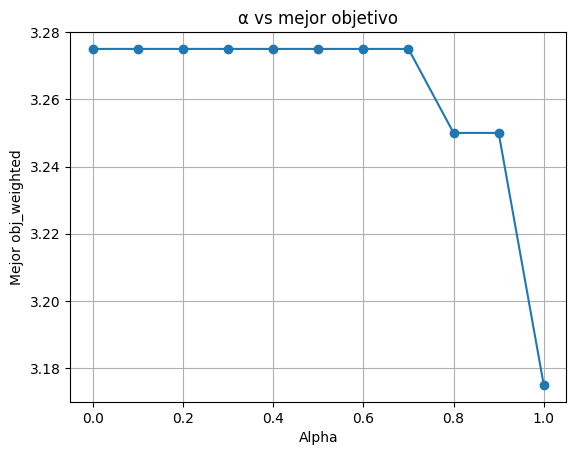

In [74]:
import matplotlib.pyplot as plt
import random

# --- Parámetros del experimento ---
ITERATIONS = 100
SEED       = 10

alphas  = [i/10 for i in range(11)]  # [0.0, 0.1, ..., 1.0]
best_objs = []

# --- Loop de sensibilidad sobre α ---
for alpha in alphas:
    random.seed(SEED)
    best_obj = -float('inf')
    for _ in range(ITERATIONS):
        # 1) Corre la simulación con el α actual
        df_cleaned, df_moves = run_iteration_chronological(alpha)

        # 2) Calcula indicadores y extrae el objetivo ponderado
        indicators, _ = compute_indicators(df_cleaned, df_moves)
        obj = indicators.get('obj_weighted', -float('inf'))

        # 3) Guardamos el mejor de estas ITERATIONS corridas
        if obj > best_obj:
            best_obj = obj

    best_objs.append(best_obj)

# --- Gráfica de sensibilidad ---
plt.figure()
plt.plot(alphas, best_objs, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mejor obj_weighted')
plt.title('α vs mejor objetivo')
plt.grid(True)
plt.show()


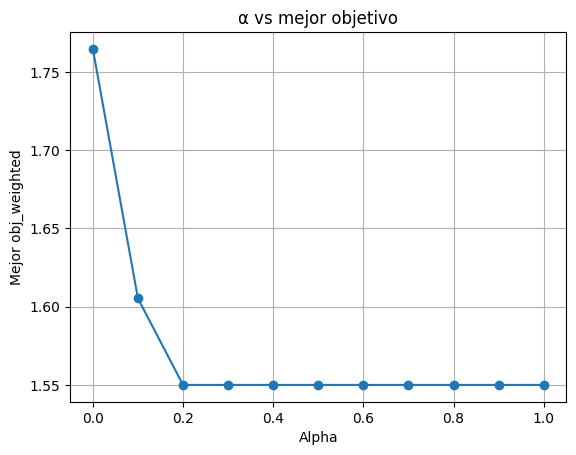

In [76]:
import matplotlib.pyplot as plt
import random

# --- Parámetros del experimento ---
ITERATIONS = 100
SEED       = 10

alphas  = [i/10 for i in range(11)]  # [0.0, 0.1, ..., 1.0]
best_objs = []

# --- Loop de sensibilidad sobre α ---
for alpha in alphas:
    random.seed(SEED)
    best_obj = -float('inf')
    for _ in range(ITERATIONS):
        # 1) Corre la simulación con el α actual
        df_cleaned, df_moves = run_iteration_chronological(alpha)

        # 2) Calcula indicadores y extrae el objetivo ponderado
        indicators, _ = compute_indicators(df_cleaned, df_moves)
        obj = indicators.get('obj_weighted', -float('inf'))

        # 3) Guardamos el mejor de estas ITERATIONS corridas
        if obj > best_obj:
            best_obj = obj

    best_objs.append(best_obj)

# --- Gráfica de sensibilidad ---
plt.figure()
plt.plot(alphas, best_objs, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mejor obj_weighted')
plt.title('α vs mejor objetivo')
plt.grid(True)
plt.show()


In [53]:
import folium
import requests
import json

OSRM_URL = "http://router.project-osrm.org/route/v1/driving/"

def parse_wkt_point(wkt_str):
    lon, lat = map(float, wkt_str.lstrip("POINT").strip("() ").split())
    return lat, lon

def osrm_route(p1, p2):
    coord_str = f"{p1[1]},{p1[0]};{p2[1]},{p2[0]}"
    r = requests.get(f"{OSRM_URL}{coord_str}?overview=full&geometries=geojson")
    r.raise_for_status()
    coords = r.json()["routes"][0]["geometry"]["coordinates"]
    return [[lat, lon] for lon, lat in coords]

def plot_driver_path(df_moves, driver_name, zoom_start=12):
    # 1) Filtrar y ordenar
    df_drv = (
        df_moves[df_moves["assigned_driver"] == driver_name]
        .sort_values("actual_start")
        .reset_index(drop=True)
    )
    if df_drv.empty:
        raise ValueError(f"No hay movimientos para el conductor {driver_name}")

    # 2) Construir secuencia de puntos y eventos
    seq = []
    events = []
    for _, row in df_drv.iterrows():
        sp = parse_wkt_point(row["start_point"])
        ep = parse_wkt_point(row["end_point"])
        events.append({"coord": sp, "service": row["service_id"], "labor": row["labor_id"], "time": row["actual_start"]})
        events.append({"coord": ep, "service": row["service_id"], "labor": row["labor_id"], "time": row["actual_end"]})
        if not seq or seq[-1] != sp:
            seq.append(sp)
        if seq[-1] != ep:
            seq.append(ep)

    # 3) Inicializar mapa
    lats, lons = zip(*seq)
    center = [sum(lats)/len(lats), sum(lons)/len(lons)]
    m = folium.Map(location=center, zoom_start=zoom_start)

    # 4) Paleta “folium friendly”
    folium_colors = [
        'red','blue','green','purple','darkred','darkblue','darkgreen',
        'cadetblue','magenta','darkpurple','lightgray'
    ]

    # 5) Dibujar cada tramo con color cíclico de esa paleta
    for i, (p0, p1) in enumerate(zip(seq, seq[1:])):
        color = folium_colors[i % len(folium_colors)]
        try:
            route = osrm_route(p0, p1)
            folium.PolyLine(route, color=color, weight=4, opacity=0.7).add_to(m)
        except:
            folium.PolyLine([p0, p1], color=color, weight=2, dash_array="5,5").add_to(m)

    # 6) Añadir marcadores con popups
    seen = set()
    for ev in events:
        key = (ev["coord"], ev["service"], ev["labor"], ev["time"])
        if key in seen:
            continue
        seen.add(key)
        popup_html = (
            f"<b>Servicio:</b> {ev['service']}<br>"
            f"<b>Labor:</b> {ev['labor']}<br>"
            f"<b>Hora:</b> {ev['time'].strftime('%Y-%m-%d %H:%M')}"
        )
        folium.CircleMarker(
            location=ev["coord"],
            radius=5,
            color="black",
            fill=True,
            fill_color="white",
            popup=folium.Popup(popup_html, max_width=200)
        ).add_to(m)

    return m
m = plot_driver_path(df_moves, "Jhon Fredy Grajales")
m  


# Modulo dinámico


#### Carga de datos

In [55]:
# ── BLOQUE 1: PREPROCESAMIENTO Y REMAPEO ─────────────────────────────────

import pandas as pd
from datetime import datetime, timedelta
import pickle
import math
import requests
import random
from filtros_df import filter_labors_by_date, filter_labors_by_city

# Parámetros de fechas
start_date    = "2024-10-21"
base_day      = pd.to_datetime(start_date).date()
dynamic_start = "2024-10-22"
dynamic_end   = "2024-10-23"

# 1) Cargar y filtrar
df_dynamic = (
    filter_labors_by_date(df_bogota,
                          start_date=dynamic_start,
                          end_date=dynamic_end)
    .query("state_service!='CANCELED'")
    .sort_values(['service_id','labor_start_date'])
    .reset_index(drop=True)
)

# 2) Remapear todas las fechas al mismo día base (manteniendo horas)
delta_days = (pd.to_datetime(dynamic_start).date() - base_day).days
for c in ['schedule_date','labor_start_date','labor_end_date']:
    df_dynamic[c] = df_dynamic[c] - timedelta(days=delta_days)

# 3) Reconstruir services_map_df dinámico (idéntico a estático)
map_src = df_dynamic[[
    'service_id','labor_id','labor_category',
    'start_address_point','end_address_point','address_point',
    'labor_start_date'
]].sort_values(['service_id','labor_start_date']).reset_index(drop=True)

rows = []
for svc, grp in map_src.groupby('service_id', sort=False):
    n = len(grp)
    for i, r in grp.iterrows():
        if n == 1:
            sp, ep = r['start_address_point'], r['end_address_point']
        else:
            if r['labor_category']=='VEHICLE_TRANSPORTATION':
                sp = r['start_address_point']
                ep = grp.iloc[i+1]['end_address_point'] if i<n-1 else r['end_address_point']
            else:
                sp = ep = r['address_point']
        rows.append({
            'service_id':      svc,
            'labor_id':        r['labor_id'],
            'map_start_point': sp,
            'map_end_point':   ep
        })
services_map_dyn = pd.DataFrame(rows)
services_map_dyn['labor_id'] = services_map_dyn['labor_id'].astype(df_dynamic['labor_id'].dtype)

# 4) Construir df_cleaned_dyn_template usando process_group
cleaned = []
for svc, grp in df_dynamic.groupby('service_id', sort=False):
    pg = process_group(grp)
    if not pg.empty:
        cleaned.append(pg)
df_cleaned_dyn_template = (
    pd.concat(cleaned, ignore_index=True)
      .merge(services_map_dyn, on=['service_id','labor_id'], how='left')
)

# ——————————————————————————————
# AÑADIMOS schedule_date_din = schedule_date - 2h
# ——————————————————————————————
df_cleaned_dyn_template['schedule_date_din'] = (
    df_cleaned_dyn_template['schedule_date'] - pd.Timedelta(hours=2)
)

# 5) Extraer ventanas FREE_TIME de la parte estática
free_windows = (
    df_moves
      .query("labor_category=='FREE_TIME'")
      [['assigned_driver','actual_start','actual_end','start_point']]
      .rename(columns={
          'actual_start':'win_start',
          'actual_end':  'win_end',
          'start_point':'win_pos'
      })
)
windows = []
for _, w in free_windows.iterrows():
    windows.append({
        'driver': w['assigned_driver'],
        'pos':    w['win_pos'],
        'avail':  w['win_start'],
        'end':    w['win_end']
    })


# 6) Guardar para usar en el Bloque 2
df_cleaned_dyn_template.to_pickle('cleaned_dyn_template.pkl')

# Ahora puedes inspeccionar / modificar:
df_cleaned_dyn_template


,service_id,labor_id,labor_type,labor_name,labor_category,labor_price,labor_created_at,labor_start_date,labor_end_date,alfred,...,service_mode,address_id,address_point,address_name,start_to_point,point_to_end,start_to_end,map_start_point,map_end_point,schedule_date_din
0,159198,247865.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,46232.0,2024-09-16 13:32:05.640000-05:00,2024-10-21 07:35:00-05:00,2024-10-21 09:08:00-05:00,6229.0,...,WITH_DRIVER,<NA>,NaN,NaN,<NA>,<NA>,4.84752,POINT (-74.03846490000001 4.6872119),POINT (-74.02394079999999 4.728333399999999),2024-10-21 06:00:00-05:00
1,159199,247866.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,46232.0,2024-09-16 13:33:41.776000-05:00,2024-10-21 16:49:00-05:00,2024-10-21 17:50:00-05:00,5409.0,...,WITH_DRIVER,<NA>,NaN,NaN,<NA>,<NA>,4.84752,POINT (-74.02394079999999 4.728333399999999),POINT (-74.03846490000001 4.6872119),2024-10-21 15:00:00-05:00
2,166446,255646.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,44530.0,2024-10-04 15:40:24.999000-05:00,2024-10-21 06:58:00-05:00,2024-10-21 08:53:00-05:00,4006.0,...,WITH_DRIVER,<NA>,NaN,NaN,<NA>,<NA>,9.151881,POINT (-74.0946233 4.7520235),POINT (-74.11402149999999 4.6720214),2024-10-21 05:30:00-05:00
3,170443,259846.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,44530.0,2024-10-15 10:35:37.089000-05:00,2024-10-21 06:44:00-05:00,2024-10-21 07:20:00-05:00,719.0,...,WITH_DRIVER,<NA>,NaN,NaN,<NA>,<NA>,11.938087,POINT (-74.1118494 4.663076),POINT (-74.065413 4.759951),2024-10-21 05:00:00-05:00
4,170538,259945.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,39588.0,2024-10-15 15:00:15.072000-05:00,2024-10-21 09:48:00-05:00,2024-10-21 10:59:00-05:00,10451.0,...,WITH_DRIVER,<NA>,NaN,NaN,<NA>,<NA>,4.815425,POINT (-74.1555322 4.6527157),POINT (-74.1127455 4.6451826),2024-10-21 08:00:00-05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,173617,263200.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,39588.0,2024-10-22 15:07:30.075000-05:00,2024-10-21 16:47:00-05:00,2024-10-21 18:29:00-05:00,6228.0,...,WITH_DRIVER,<NA>,NaN,NaN,<NA>,<NA>,3.068088,POINT (-74.1127455 4.6451826),POINT (-74.1255788 4.6696307),2024-10-21 15:00:00-05:00
76,173627,263212.0,12.0,Alfred Initial Transport,VEHICLE_TRANSPORTATION,52003.0,2024-10-22 15:30:45.926000-05:00,2024-10-21 16:37:00-05:00,2024-10-21 17:31:00-05:00,5832.0,...,WITH_DRIVER,<NA>,NaN,NaN,<NA>,<NA>,2.511685,POINT (-74.1145559 4.6716483),POINT (-74.1306479 4.6875541),2024-10-21 14:30:00-05:00
77,173627,263213.0,6.0,General Mechanics,GENERAL_MECHANICS,1329230.0,2024-10-22 15:30:45.986000-05:00,2024-10-21 17:31:00-05:00,2024-10-23 11:58:00-05:00,NaN,...,WITH_DRIVER,56315,POINT (-74.07426269999999 4.651892),Autodealer,4.976677,7.400943,2.511685,POINT (-74.07426269999999 4.651892),POINT (-74.07426269999999 4.651892),2024-10-21 14:30:00-05:00
78,173627,264227.0,2.0,Alfred Transport,VEHICLE_TRANSPORTATION,52003.0,2024-10-24 11:56:23.916000-05:00,2024-10-23 11:58:00-05:00,2024-10-23 13:33:00-05:00,26348.0,...,WITH_DRIVER,<NA>,NaN,NaN,<NA>,<NA>,2.511685,POINT (-74.1145559 4.6716483),POINT (-74.1306479 4.6875541),2024-10-21 14:30:00-05:00


#### Asignaciones dinamicas

In [ ]:
# ── BLOQUE 2: ASIGNACIÓN DINÁMICA + RECONSTRUCCIÓN DE TIMELINE Y GANTT ────────────────

import pandas as pd
import random
import math
from datetime import datetime, timedelta
import plotly.express as px

# — Parámetros & Seed —————————————————————————————————————————————————────────
alfred_speed            = 30
vehicle_transport_speed = 35
tiempo_previo           = 30
tiempo_gracia           = 15
tiempo_alistar          = 15
tiempo_finalizacion     = 15
SEED                    = 10
ALPHA_din               = 1

random.seed(SEED)  # garantiza reproducibilidad

# — 1) Cargar plantilla preprocesada ————————————————————————————————————————
df_cleaned = pd.read_pickle('cleaned_dyn_template.pkl')
# df_cleaned ya contiene las columnas:
#   service_id, labor_id, labor_category, map_start_point, map_end_point,
#   schedule_date, labor_start_date, labor_end_date, schedule_date_din, ...

# — 2) Reconstruir ventanas FREE_TIME desde la parte estática ——————————————————
free_windows = (
    df_moves
      .query("labor_category=='FREE_TIME'")
      [['assigned_driver','actual_start','actual_end','start_point']]
      .rename(columns={
          'actual_start':'win_start',
          'actual_end':  'win_end',
          'start_point':'win_pos'
      })
)
windows = [
    {'driver': w['assigned_driver'],
     'pos':    w['win_pos'],
     'avail':  w['win_start'],
     'end':    w['win_end']}
    for _, w in free_windows.iterrows()
]

# — 3) Definir orden de llegada de servicios por schedule_date_din ——————————————
service_order = (
    df_cleaned
      .groupby('service_id', sort=False)
      .agg(first_din=('schedule_date_din','first'))
      .reset_index()
      .sort_values('first_din')
      ['service_id']
      .tolist()
)

# — 4) ASIGNACIÓN DINÁMICA (DRIVER_MOVE + VEHICLE_TRANSPORTATION) ———————————————
dyn_recs = []
for svc in service_order:
    grp = df_cleaned[df_cleaned['service_id']==svc]
    prev_end = None

    # iteramos EN EL ORDEN que ya tenía dentro de cada servicio
    for idx, row in grp.iterrows():
        sched = row['schedule_date']

        if row['labor_category']=='VEHICLE_TRANSPORTATION':
            early = prev_end if prev_end is not None else sched - timedelta(minutes=tiempo_previo)
            late  = (prev_end + timedelta(minutes=tiempo_gracia)
                     if prev_end is not None else sched + timedelta(minutes=tiempo_gracia))

            # calcular duración del VEHICLE_TRANSPORTATION
            dkm_s   = distance(row['map_start_point'], row['map_end_point'], method=DISTANCE_METHOD)
            drive_s = 0 if math.isnan(dkm_s) else dkm_s/vehicle_transport_speed*60
            dur_s   = tiempo_alistar + drive_s + (
                          tiempo_finalizacion if idx==len(grp)-1 else 0
                      )

            # buscar candidatos en ventanas free_time
            cands = []
            for w in windows:
                dkm_m   = distance(w['pos'], row['map_start_point'], method=DISTANCE_METHOD)
                t_move  = timedelta(minutes=(0 if math.isnan(dkm_m) else dkm_m/alfred_speed*60))
                arrival = max(w['avail'], early) + t_move
                finish  = arrival + timedelta(minutes=dur_s)
                if arrival <= late and finish <= w['end']:
                    cands.append({'win':w,'arrival':arrival,'t_move':t_move})

            pick = select_from_candidates(cands, ALPHA_din) if cands else None

            if pick:
                w        = pick['win']
                arr      = pick['arrival']
                depart   = arr - pick['t_move']
                end_serv = arr + timedelta(minutes=dur_s)

                # DRIVER_MOVE dinámico
                dyn_recs.append({
                    'service_id':      svc,
                    'labor_id':        f"{int(row['labor_id'])}_move_dyn",
                    'labor_name':      'DRIVER_MOVE',
                    'labor_category':  'DRIVER_MOVE',
                    'assigned_driver': w['driver'],
                    'schedule_date':   depart,
                    'actual_start':    depart,
                    'actual_end':      arr,
                    'start_point':     w['pos'],
                    'end_point':       row['map_start_point'],
                    'src':             'Dinámico'
                })
                # VEHICLE_TRANSPORTATION dinámico
                dyn_recs.append({
                    'service_id':      svc,
                    'labor_id':        row['labor_id'],
                    'labor_name':      row['labor_name'],
                    'labor_category':  'VEHICLE_TRANSPORTATION',
                    'assigned_driver': w['driver'],
                    'schedule_date':   arr,
                    'actual_start':    arr,
                    'actual_end':      end_serv,
                    'start_point':     row['map_start_point'],
                    'end_point':       row['map_end_point'],
                    'src':             'Dinámico'
                })

                # actualizar ventana y prev_end
                w['avail'], w['pos'], prev_end = end_serv, row['map_end_point'], end_serv

            else:
                # asignación fallida
                dyn_recs.append({
                    'service_id':      svc,
                    'labor_id':        row['labor_id'],
                    'labor_name':      row['labor_name'],
                    'labor_category':  'VEHICLE_TRANSPORTATION',
                    'assigned_driver': pd.NA,
                    'schedule_date':   sched,
                    'actual_start':    pd.NaT,
                    'actual_end':      pd.NaT,
                    'start_point':     row['map_start_point'],
                    'end_point':       row['map_end_point'],
                    'src':             'Dinámico'
                })
                prev_end = None

        else:
            # tareas no‐transporte (igual que estático)
            astart = prev_end if prev_end is not None else sched
            adur   = avg_times_map.get(row['labor_name'], tiempo_other)
            aend   = astart + timedelta(minutes=adur)
            dyn_recs.append({
                'service_id':      svc,
                'labor_id':        row['labor_id'],
                'labor_name':      row['labor_name'],
                'labor_category':  row['labor_category'],
                'assigned_driver': pd.NA,
                'schedule_date':   sched,
                'actual_start':    astart,
                'actual_end':      aend,
                'start_point':     row['map_start_point'],
                'end_point':       row['map_end_point'],
                'src':             'Dinámico'
            })
            prev_end = aend

# — 5) RECONSTRUIR TIMELINE COMPLETO (FREE_TIME + DRIVER_MOVE + SERVICE) ————————
svc_static = df_moves.query("labor_category=='VEHICLE_TRANSPORTATION'").copy()
svc_static['src'] = 'Estático'
svc_dyn    = pd.DataFrame(dyn_recs).query("labor_category=='VEHICLE_TRANSPORTATION'").copy()

all_services = pd.concat([svc_static, svc_dyn], ignore_index=True)
all_services = all_services.sort_values(['assigned_driver','actual_start']).reset_index(drop=True)

# posiciones iniciales
initial = {}
tz        = df_moves['schedule_date'].dt.tz
first_date= df_moves['schedule_date'].dt.date.min()
for _, d in directorio_df[directorio_df['city']=='BOGOTA'].iterrows():
    if pd.isna(d['latitud']): continue
    nm = d["ALFRED'S"]
    initial[nm] = {
        'pos': f"POINT ({d['longitud']} {d['latitud']})",
        'end': pd.Timestamp(
            datetime.combine(first_date,
                             datetime.strptime(d['start_time'],'%H:%M:%S').time()
            )).tz_localize(tz)
    }

# arma el timeline
timeline = []
for driver, grp in all_services.groupby('assigned_driver'):
    last_pos = initial[driver]['pos']
    last_end = initial[driver]['end']
    for _, e in grp.iterrows():
        start, end = e['actual_start'], e['actual_end']
        sp, ep     = e['start_point'], e['end_point']
        # FREE_TIME
        dkm_m  = distance(last_pos, sp, method=DISTANCE_METHOD)
        t_m    = timedelta(minutes=(0 if math.isnan(dkm_m) else dkm_m/alfred_speed*60))
        depart = max(last_end, start - t_m)
        if depart > last_end:
            timeline.append({
                'service_id':     pd.NA,
                'labor_id':       f"{driver}_free",
                'labor_name':     'FREE_TIME',
                'labor_category':'FREE_TIME',
                'assigned_driver':driver,
                'schedule_date':  depart,
                'actual_start':   last_end,
                'actual_end':     depart,
                'start_point':    last_pos,
                'end_point':      last_pos,
                'src':            ''
            })
        # DRIVER_MOVE
        timeline.append({
            'service_id':     e['service_id'],
            'labor_id':       f"{int(e['labor_id'])}_move",
            'labor_name':     'DRIVER_MOVE',
            'labor_category':'DRIVER_MOVE',
            'assigned_driver':driver,
            'schedule_date':  e['schedule_date'],
            'actual_start':   depart,
            'actual_end':     start,
            'start_point':    last_pos,
            'end_point':      sp,
            'src':            e['src']
        })
        # SERVICE
        timeline.append({
            'service_id':      e['service_id'],
            'labor_id':        int(e['labor_id']),
            'labor_name':      e['labor_name'],
            'labor_category':  e['labor_category'],
            'assigned_driver': driver,
            'schedule_date':   e['schedule_date'],
            'actual_start':    start,
            'actual_end':      end,
            'start_point':     sp,
            'end_point':       ep,
            'src':             e['src']
        })
        last_end = end
        last_pos = ep

# DataFrame de timeline final
# df_tl = pd.DataFrame(timeline)
# df_tl['duration_min'] = (
#     (df_tl['actual_end'] - df_tl['actual_start']).dt.total_seconds()/60
# ).round(1)

# — DataFrame de timeline final y cálculo de duration_min ——————————————————————
df_tl = pd.DataFrame(timeline)

# FORZAMOS actual_start y actual_end a datetime, respetando el tz y luego quitándolo
df_tl['actual_start'] = pd.to_datetime(df_tl['actual_start'], utc=True).dt.tz_convert(None)
df_tl['actual_end']   = pd.to_datetime(df_tl['actual_end'],   utc=True).dt.tz_convert(None)

# Ahora sí podemos usar .dt para calcular duration_min
df_tl['duration_min'] = (
    (df_tl['actual_end'] - df_tl['actual_start'])
    .dt.total_seconds() / 60
).round(1)

# **Dejo disponible para métricas**  
df_timeline = df_tl.copy()


# — 6) GANTT combinado con diferenciación —————————————————————————————————————
def darken_hex(hex_color, factor=0.5):
    hex_color = hex_color.lstrip('#')
    r, g, b    = (int(hex_color[i:i+2], 16) for i in (0,2,4))
    r, g, b    = int(r*factor), int(g*factor), int(b*factor)
    return f'#{r:02x}{g:02x}{b:02x}'

show = ['FREE_TIME','DRIVER_MOVE','VEHICLE_TRANSPORTATION']
df_plot = df_timeline[df_timeline['labor_category'].isin(show)].copy()
df_plot['cat_src'] = df_plot.apply(
    lambda r: 'FREE_TIME'
              if r['labor_category']=='FREE_TIME'
              else f"{r['labor_category']}_{r['src']}",
    axis=1
)

colors = {
    'FREE_TIME':                      'gray',
    'DRIVER_MOVE_Estático':           px.colors.qualitative.Plotly[0],
    'DRIVER_MOVE_Dinámico':           darken_hex(px.colors.qualitative.Plotly[0],0.5),
    'VEHICLE_TRANSPORTATION_Estático':px.colors.qualitative.Plotly[1],
    'VEHICLE_TRANSPORTATION_Dinámico':darken_hex(px.colors.qualitative.Plotly[1],0.5)
}

fig = px.timeline(
    df_plot,
    x_start="actual_start", x_end="actual_end",
    y="assigned_driver",
    color="cat_src",
    color_discrete_map=colors,
    hover_data={
        "labor_name": True, "service_id": True, "labor_id": True,
        "schedule_date": True, "duration_min": True,
        "start_point": True, "end_point": True, "src": True
    }
)
fig.update_yaxes(autorange="reversed")
fig.update_layout(height=600, title="Comparativo Estático vs Dinámico")
fig.show()


In [66]:
from datetime import timedelta

def compute_metrics(df_moves, grace=tiempo_gracia, other=tiempo_other):
    """
    Recibe un DataFrame con columnas:
      - service_id, labor_category, assigned_driver
      - schedule_date, actual_start, actual_end
      - duration_min
    y devuelve un Series con los indicadores.
    """
    # Copiamos para no mutar el original
    df = df_moves.copy()

    # 0) Deslocalizar timestamps si tuvieran tz
    df['schedule_date'] = pd.to_datetime(df['schedule_date'], utc=True).dt.tz_convert(None)
    df['actual_start']  = pd.to_datetime(df['actual_start'],  utc=True).dt.tz_convert(None)

    # 1) Tiempo libre
    free_min  = df.loc[df['labor_category']=='FREE_TIME', 'duration_min'].sum()
    total_min = df['duration_min'].sum()
    pct_free  = 100 * free_min / total_min if total_min > 0 else 0

    # 2) Asignaciones fallidas (servicios sin ningún driver)
    failed_count = (
        df.groupby('service_id')['assigned_driver']
          .apply(lambda x: x.isna().all())
          .sum()
    )
    total_svcs = df['service_id'].nunique()
    pct_failed = 100 * failed_count / total_svcs if total_svcs > 0 else 0

    # 3) Llegadas tarde (solo la primera VT de cada servicio)
    first_tasks = (
        df[df['labor_category']=='VEHICLE_TRANSPORTATION']
          .sort_values('schedule_date')
          .groupby('service_id', as_index=False).first()
    )
    late_dead    = first_tasks['schedule_date'] + timedelta(minutes=grace)
    raw_lateness = first_tasks['actual_start'] - late_dead
    n_late       = (raw_lateness > timedelta(0)).sum()

    # 4) Tardanza normalizada
    capped = raw_lateness.apply(lambda x: 
        timedelta(0) if x <= timedelta(0) 
        else min(x, timedelta(minutes=grace))
    )
    total_tardy_norm = capped.dt.total_seconds().sum() / (grace * total_svcs) if total_svcs > 0 else 0

    # 5) Promedio de servicios por conductor
    drv_assigned = df[df['assigned_driver'].notna()]
    if not drv_assigned.empty:
        avg_per_driver = drv_assigned.groupby('assigned_driver')['service_id'].nunique().mean()
    else:
        avg_per_driver = 0.0

    # 6) Objetivo ponderado
    obj_weighted = pct_free*0 + pct_failed*0 + total_tardy_norm*0 + avg_per_driver*0.5

    return pd.Series({
        '% Tiempo Libre':              f"{pct_free:.1f}%",
        '% Asign. Falladas':           f"{pct_failed:.1f}%",
        'N° Llegadas Tarde':           int(n_late),
        '% Tardanza (norm.)':          f"{total_tardy_norm*100:.1f}%",
        'Prom. Servicios x Conductor': f"{avg_per_driver:.2f}",
        'Obj Weighted':                f"{obj_weighted:.3f}"
    })

# Bloque 2 dinamico
compute_metrics(df_timeline)

% Tiempo Libre                  41.0%
% Asign. Falladas                0.0%
N° Llegadas Tarde                   7
% Tardanza (norm.)             424.2%
Prom. Servicios x Conductor      5.65
Obj Weighted                    2.825
dtype: object

#### Asignación dinámica con buffer

In [ ]:
# ── BLOQUE 3: ASIGNACIÓN DINÁMICA CON BUFFER y ALPHA_BUFFER ─────────────────

import pandas as pd
import random
import math
from datetime import datetime, timedelta
import plotly.express as px

# — Parámetros & Seed —————————————————————————————————————————————————────────
alfred_speed            = 30
vehicle_transport_speed = 40
tiempo_previo           = 30
tiempo_gracia           = 15
tiempo_alistar          = 15
tiempo_finalizacion     = 15

BUFFER_TIME    = 60    # minutos por ventana
BUFFER_SEED    = 100   # semilla para reproducibilidad
ALPHA_BUFFER   = 0     # 0 = aleatorio, 1 = greedy por schedule_date_din

random.seed(BUFFER_SEED)

# — 1) Cargo plantilla y ventanas FREE_TIME estáticas ————————————————————————
df_cleaned = pd.read_pickle('cleaned_dyn_template.pkl')

free_windows = (
    df_moves
      .query("labor_category=='FREE_TIME'")
      [['assigned_driver','actual_start','actual_end','start_point']]
      .rename(columns={
          'actual_start':'win_start',
          'actual_end':  'win_end',
          'start_point':'win_pos'
    })
)
windows = [
    {'driver': w['assigned_driver'],
     'pos':    w['win_pos'],
     'avail':  w['win_start'],
     'end':    w['win_end']}
    for _, w in free_windows.iterrows()
]

# — 2) Eventos y ventanas ————————————————————————————————————————————————
df_events = df_cleaned.copy()
min_din = df_events['schedule_date_din'].min().floor('T')
max_din = df_events['schedule_date_din'].max().ceil('T')

window_starts = pd.date_range(
    start=min_din,
    end=max_din,
    freq=f'{BUFFER_TIME}min'
)

# — 3) Asignación por ventanas con ALPHA_BUFFER ——————————————————————————
dyn_buffer_recs = []

for win_start in window_starts:
    win_end = win_start + timedelta(minutes=BUFFER_TIME)

    # 3.1) Extraigo las órdenes de esta ventana
    ev_win = df_events[
        (df_events['schedule_date_din'] >= win_start) &
        (df_events['schedule_date_din'] < win_end)
    ].copy()

    # 3.2) Ordeno según ALPHA_BUFFER
    if ALPHA_BUFFER == 0:
        ev_win = ev_win.sample(frac=1, random_state=BUFFER_SEED).reset_index(drop=True)
    else:
        ev_win = ev_win.sort_values('schedule_date_din').reset_index(drop=True)

    # 3.3) Itero en ese orden
    for idx, row in ev_win.iterrows():
        svc   = row['service_id']
        sched = row['schedule_date']
        cat   = row['labor_category']

        if cat == 'VEHICLE_TRANSPORTATION':
            # early/late idéntico al estático
            early = row.get('prev_end', sched - timedelta(minutes=tiempo_previo))
            late  = early + timedelta(minutes=tiempo_previo + tiempo_gracia)

            # calculo duración del servicio
            dkm_s   = distance(row['map_start_point'], row['map_end_point'], method=DISTANCE_METHOD)
            drive_s = 0 if math.isnan(dkm_s) else dkm_s/vehicle_transport_speed*60
            dur_s   = tiempo_alistar + drive_s + (
                          tiempo_finalizacion if idx==len(ev_win)-1 else 0
                      )

            # candidatos en free_time
            cands = []
            for w in windows:
                dkm_m   = distance(w['pos'], row['map_start_point'], method=DISTANCE_METHOD)
                t_move  = timedelta(minutes=(0 if math.isnan(dkm_m) else dkm_m/alfred_speed*60))
                arrival = max(w['avail'], early) + t_move
                finish  = arrival + timedelta(minutes=dur_s)
                if arrival <= late and finish <= w['end']:
                    cands.append({'win':w,'arrival':arrival,'t_move':t_move})

            # selección según ALPHA_BUFFER
            pick = select_from_candidates(cands, ALPHA_BUFFER) if cands else None

            if pick:
                w      = pick['win']
                arr    = pick['arrival']
                depart = arr - pick['t_move']
                end_s  = arr + timedelta(minutes=dur_s)

                # DRIVER_MOVE_Buffer
                dyn_buffer_recs.append({
                    'service_id':      svc,
                    'labor_id':        f"{int(row['labor_id'])}_move_buf",
                    'labor_name':      'DRIVER_MOVE',
                    'labor_category':  'DRIVER_MOVE',
                    'assigned_driver': w['driver'],
                    'schedule_date':   depart,
                    'actual_start':    depart,
                    'actual_end':      arr,
                    'start_point':     w['pos'],
                    'end_point':       row['map_start_point'],
                    'src':             'Buffer'
                })
                # VEHICLE_TRANSPORTATION_Buffer
                dyn_buffer_recs.append({
                    'service_id':      svc,
                    'labor_id':        row['labor_id'],
                    'labor_name':      row['labor_name'],
                    'labor_category':  'VEHICLE_TRANSPORTATION',
                    'assigned_driver': w['driver'],
                    'schedule_date':   arr,
                    'actual_start':    arr,
                    'actual_end':      end_s,
                    'start_point':     row['map_start_point'],
                    'end_point':       row['map_end_point'],
                    'src':             'Buffer'
                })

                # actualizo ventana y marco prev_end
                w['avail'], w['pos'] = end_s, row['map_end_point']
                ev_win.at[idx,'prev_end'] = end_s

            else:
                # fallido
                dyn_buffer_recs.append({
                    'service_id':      svc,
                    'labor_id':        row['labor_id'],
                    'labor_name':      row['labor_name'],
                    'labor_category':  'VEHICLE_TRANSPORTATION',
                    'assigned_driver': pd.NA,
                    'schedule_date':   sched,
                    'actual_start':    pd.NaT,
                    'actual_end':      pd.NaT,
                    'start_point':     row['map_start_point'],
                    'end_point':       row['map_end_point'],
                    'src':             'Buffer'
                })

        else:
            # no‐transportes igual que estático
            astart = row.get('prev_end', sched)
            adur   = avg_times_map.get(row['labor_name'], tiempo_other)
            aend   = astart + timedelta(minutes=adur)
            dyn_buffer_recs.append({
                'service_id':      svc,
                'labor_id':        row['labor_id'],
                'labor_name':      row['labor_name'],
                'labor_category':  row['labor_category'],
                'assigned_driver': pd.NA,
                'schedule_date':   sched,
                'actual_start':    astart,
                'actual_end':      aend,
                'start_point':     row['map_start_point'],
                'end_point':       row['map_end_point'],
                'src':             'Buffer'
            })
            ev_win.at[idx,'prev_end'] = aend

# — 4) Concateno y reconstruyo timeline igual que antes ———————————————————————
svc_static = (
    df_moves
      .query("labor_category=='VEHICLE_TRANSPORTATION'")
      .assign(src='Estático')
)
svc_buf = (
    pd.DataFrame(dyn_buffer_recs)
      .query("labor_category=='VEHICLE_TRANSPORTATION'")
)

all_srv = pd.concat([svc_static, svc_buf], ignore_index=True)
all_srv = all_srv.sort_values(['assigned_driver','actual_start']).reset_index(drop=True)

# reconstruyo FREE_TIME + DRIVER_MOVE + SERVICE
timeline = []
initial  = {}
tz       = df_moves['schedule_date'].dt.tz
fd       = df_moves['schedule_date'].dt.date.min()

for _, d in directorio_df[directorio_df['city']=='BOGOTA'].iterrows():
    if pd.isna(d['latitud']): continue
    nm = d["ALFRED'S"]
    initial[nm] = {
        'pos': f"POINT ({d['longitud']} {d['latitud']})",
        'end': pd.Timestamp(
            datetime.combine(fd, datetime.strptime(d['start_time'],'%H:%M:%S').time())
        ).tz_localize(tz)
    }

for driver, grp in all_srv.groupby('assigned_driver'):
    last_pos = initial[driver]['pos']
    last_end = initial[driver]['end']
    for _, e in grp.iterrows():
        start, end = e['actual_start'], e['actual_end']
        sp, ep     = e['start_point'], e['end_point']
        # FREE_TIME
        dkm_m  = distance(last_pos, sp, method=DISTANCE_METHOD)
        t_m    = timedelta(minutes=(0 if math.isnan(dkm_m) else dkm_m/alfred_speed*60))
        depart = max(last_end, start - t_m)
        if depart > last_end:
            timeline.append({
                'service_id':     pd.NA,
                'labor_id':       f"{driver}_free",
                'labor_name':     'FREE_TIME',
                'labor_category':'FREE_TIME',
                'assigned_driver':driver,
                'schedule_date':  depart,
                'actual_start':   last_end,
                'actual_end':     depart,
                'start_point':    last_pos,
                'end_point':      last_pos,
                'src':            ''
            })
        # DRIVER_MOVE
        timeline.append({
            'service_id':     e['service_id'],
            'labor_id':       f"{int(e['labor_id'])}_move",
            'labor_name':     'DRIVER_MOVE',
            'labor_category':'DRIVER_MOVE',
            'assigned_driver':driver,
            'schedule_date':  e['schedule_date'],
            'actual_start':   depart,
            'actual_end':     start,
            'start_point':    last_pos,
            'end_point':      sp,
            'src':            e['src']
        })
        # SERVICE
        timeline.append({
            'service_id':      e['service_id'],
            'labor_id':        int(e['labor_id']),
            'labor_name':      e['labor_name'],
            'labor_category':  e['labor_category'],
            'assigned_driver': driver,
            'schedule_date':   e['schedule_date'],
            'actual_start':    start,
            'actual_end':      end,
            'start_point':     sp,
            'end_point':       ep,
            'src':             e['src']
        })
        last_end = end
        last_pos = ep

# DataFrame de timeline final para buffer
df_tl = pd.DataFrame(timeline)
df_tl['duration_min'] = (
    (df_tl['actual_end'] - df_tl['actual_start']).dt.total_seconds()/60
).round(1)

# **Dejo disponible para métricas**  
df_timeline_buffer = df_tl.copy()

# — 5) Dibujo GANTT combinado —————————————————————————————————————————————
def darken_hex(hex_color, factor=0.5):
    h = hex_color.lstrip('#')
    r,g,b = (int(h[i:i+2],16) for i in (0,2,4))
    return f'#{int(r*factor):02x}{int(g*factor):02x}{int(b*factor):02x}'

show = ['FREE_TIME','DRIVER_MOVE','VEHICLE_TRANSPORTATION']
df_plot = df_timeline_buffer[df_timeline_buffer['labor_category'].isin(show)].copy()
df_plot['cat_src'] = df_plot.apply(
    lambda r: 'FREE_TIME'
              if r['labor_category']=='FREE_TIME'
              else f"{r['labor_category']}_{r['src']}",
    axis=1
)

colors = {
    'FREE_TIME':                        'gray',
    'DRIVER_MOVE_Estático':             px.colors.qualitative.Plotly[0],
    'DRIVER_MOVE_Buffer':               darken_hex(px.colors.qualitative.Plotly[0],0.5),
    'VEHICLE_TRANSPORTATION_Estático':  px.colors.qualitative.Plotly[1],
    'VEHICLE_TRANSPORTATION_Buffer':    darken_hex(px.colors.qualitative.Plotly[1],0.5),
}

fig = px.timeline(
    df_plot,
    x_start="actual_start", x_end="actual_end",
    y="assigned_driver",
    color="cat_src",
    color_discrete_map=colors,
    hover_data=[
        "labor_name","service_id","labor_id",
        "schedule_date","duration_min",
        "start_point","end_point","src"
    ]
)
fig.update_yaxes(autorange="reversed")
fig.update_layout(
    height=600,
    title=f"Asgn. con Buffer ({'Greedy' if ALPHA_BUFFER==1 else 'Aleatorio'})"
)
fig.show()


C:\Users\Rodhy\AppData\Local\Temp\ipykernel_4840\937741341.py:46: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.

C:\Users\Rodhy\AppData\Local\Temp\ipykernel_4840\937741341.py:47: FutureWarning:

'T' is deprecated and will be removed in a future version, please use 'min' instead.



#### Cálculo de métricas

In [61]:
from datetime import timedelta

def compute_metrics(df_moves, grace=tiempo_gracia, other=tiempo_other):
    """
    Recibe un DataFrame con columnas:
      - service_id, labor_category, assigned_driver
      - schedule_date, actual_start, actual_end
      - duration_min
    y devuelve un Series con los indicadores.
    """
    # 1) Tiempo libre
    free_min  = df_moves.loc[df_moves['labor_category']=='FREE_TIME','duration_min'].sum()
    total_min = df_moves['duration_min'].sum()
    pct_free  = 100 * free_min / total_min if total_min>0 else 0

    # 2) Asignaciones fallidas (servicios sin ningún driver)
    failed_count = (
        df_moves
        .groupby('service_id')['assigned_driver']
        .apply(lambda x: x.isna().all())
        .sum()
    )
    total_svcs = df_moves['service_id'].nunique()
    pct_failed = 100 * failed_count / total_svcs if total_svcs>0 else 0

    # 3) Llegadas tarde
    first_tasks = (
        df_moves[df_moves['labor_category']=='VEHICLE_TRANSPORTATION']
        .sort_values('schedule_date')
        .groupby('service_id', as_index=False).first()
    )
    late_dead    = first_tasks['schedule_date'] + timedelta(minutes=grace)
    raw_lateness = first_tasks['actual_start'] - late_dead
    n_late       = (raw_lateness > timedelta(0)).sum()

    # 4) Tardanza normalizada
    capped = raw_lateness.apply(lambda x:
        timedelta(0) if x <= timedelta(0)
        else min(x, timedelta(minutes=grace))
    )
    total_tardy_norm = capped.dt.total_seconds().sum() / (grace * total_svcs) if total_svcs>0 else 0

    # 5) Promedio de servicios por conductor
    avg_per_driver = (
        df_moves[df_moves['assigned_driver'].notna()]
        .groupby('assigned_driver')['service_id']
        .nunique()
        .mean()
    )

    # 6) Objetivo ponderado (igual al static)
    obj_weighted = pct_free*0 + pct_failed*0 + total_tardy_norm*0 + avg_per_driver*0.5

    return pd.Series({
        '% Tiempo Libre':                f"{pct_free:.1f}%",
        '% Asign. Falladas':             f"{pct_failed:.1f}%",
        'N° Llegadas Tarde':             int(n_late),
        '% Tardanza (norm.)':            f"{total_tardy_norm*100:.1f}%",
        'Prom. Servicios x Conductor':   f"{avg_per_driver:.2f}",
        'Obj Weighted':                  f"{obj_weighted:.3f}"
    })

In [24]:
# Bloque 2 dinamico
compute_metrics(df_timeline)

% Tiempo Libre                  53.0%
% Asign. Falladas                0.0%
N° Llegadas Tarde                   5
% Tardanza (norm.)             321.1%
Prom. Servicios x Conductor      5.00
Obj Weighted                    2.500
dtype: object

In [25]:
# Bloque 3 dinamico con buffer
compute_metrics(df_timeline_buffer)

% Tiempo Libre                  48.0%
% Asign. Falladas                0.0%
N° Llegadas Tarde                   3
% Tardanza (norm.)             194.4%
Prom. Servicios x Conductor      5.05
Obj Weighted                    2.525
dtype: object

In [26]:
import pickle
import pandas as pd
import math
import requests
import random
from datetime import datetime, timedelta
import plotly.express as px

# ——————————————————————————————
# Parámetros
# ——————————————————————————————
ITERATIONS            = 5
ALPHA                 = 0
SEED                  = 10
DISTANCE_METHOD       = 'Manhattan'
alfred_speed          = 30   # km/h para conductor hacia primer punto
vehicle_transport_speed = 40 # km/h para transporte de vehículo
tiempo_previo         = 30   # minutos antes del schedule_date
tiempo_gracia         = 15
tiempo_alistar        = 15
tiempo_other          = 30
tiempo_finalizacion   = 15

random.seed(SEED)

# ——————————————————————————————
# Cargar distancias precalculadas
# ——————————————————————————————
with open('distances.pkl', 'rb') as f:
    DIST_DICT = pickle.load(f)

# ——————————————————————————————
# 0) Filtrado y mix automático de días en base_day
# ——————————————————————————————
start_date = "2024-10-21"
end_date   = "2024-10-23"

df_dia = filter_labors_by_date(df_bogota, start_date=start_date, end_date=end_date)
df_dia = df_dia[df_dia['state_service'] != 'CANCELED'].copy()
df_dia = df_dia.sort_values(['service_id', 'labor_start_date']).reset_index(drop=True)

# ——————————————————————————————
# 0.2) Remapeo fechas a base_day
# ——————————————————————————————
base_day = pd.to_datetime(start_date).date()
def remap_to_base(dt: pd.Timestamp) -> pd.Timestamp:
    return dt + timedelta(days=(base_day - dt.date()).days)

df_dia['schedule_date'] = df_dia['schedule_date'].apply(remap_to_base)

# ——————————————————————————————
# 0.3) Construir services_map_df con lógica de un único labor vs múltiples
# ——————————————————————————————
map_src = df_dia[[
    'service_id', 'labor_id', 'labor_category',
    'start_address_point', 'end_address_point', 'address_point',
    'labor_start_date'
]].copy().sort_values(['service_id', 'labor_start_date']).reset_index(drop=True)

rows = []
for svc, grp in map_src.groupby('service_id', sort=False):
    n = len(grp)
    idxs = list(grp.index)
    for i, idx in enumerate(idxs):
        r = grp.loc[idx]
        if n == 1:
            sp = r['start_address_point']
            ep = r['end_address_point']
        else:
            if r['labor_category'] == 'VEHICLE_TRANSPORTATION':
                sp = r['start_address_point']
                if i < n - 1:
                    ep = grp.iloc[i+1]['end_address_point']
                else:
                    ep = r['end_address_point']
            else:
                sp = r['address_point']
                ep = r['address_point']
        rows.append({
            'service_id': svc,
            'labor_id':   r['labor_id'],
            'map_start_point': sp,
            'map_end_point':   ep
        })

services_map_df = pd.DataFrame(rows)
services_map_df['labor_id'] = services_map_df['labor_id'].astype(df_dia['labor_id'].dtype)

# ——————————————————————————————
# 1) Helper & distancia
# ——————————————————————————————
def parse_point(s):
    if pd.isna(s) or not s.strip().startswith("POINT"):
        return None, None
    lon, lat = map(float, s.lstrip('POINT').strip(' ()').split())
    return lat, lon

OSRM_URL = "http://router.project-osrm.org/route/v1/driving/"
def distance(p1, p2, method='haversine', timeout=5):
    if method == 'precalced':
        return DIST_DICT.get((p1, p2), float('nan'))
    lat1, lon1 = parse_point(p1)
    lat2, lon2 = parse_point(p2)
    if None in (lat1, lon1, lat2, lon2):
        return float('nan')
    if method == 'haversine':
        φ1, φ2 = map(math.radians, (lat1, lat2))
        dφ = math.radians(lat2 - lat1)
        dλ = math.radians(lon2 - lon1)
        a = math.sin(dφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(dλ/2)**2
        return 2 * 6371 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    if method == 'osrm':
        coords = f"{lon1},{lat1};{lon2},{lat2}"
        try:
            r = requests.get(OSRM_URL + coords + "?overview=false", timeout=timeout)
            r.raise_for_status()
            return r.json()['routes'][0]['distance'] / 1000
        except:
            return distance(p1, p2, method='haversine')
    # Manhattan
    KM_PER_DEG_LAT = 111.32
    mean_lat = math.radians((lat1 + lat2) / 2)
    dlat = abs(lat1 - lat2) * KM_PER_DEG_LAT
    dlon = abs(lon1 - lon2) * KM_PER_DEG_LAT * math.cos(mean_lat)
    return dlat + dlon

# ——————————————————————————————
# 2) Process group
# ——————————————————————————————
def process_group(grp):
    if len(grp)==1:
        return grp if grp.iloc[0]['labor_category']=='VEHICLE_TRANSPORTATION' else grp.iloc[0:0]

    A_idx = list(grp.index[grp['labor_category']=='VEHICLE_TRANSPORTATION'])
    B_idx = list(grp.index[grp['labor_category']!='VEHICLE_TRANSPORTATION'])
    B_idx = [i for i in B_idx
             if pd.notna(grp.at[i,'shop'])
             and pd.notna(grp.at[i,'address_point'])]
    if not B_idx:
        return grp.iloc[0:0]

    inits = [i for i in A_idx if grp.at[i,'labor_name']=='Alfred Initial Transport']
    firstA = inits[0] if inits else A_idx[0]
    A_remain = [i for i in A_idx if i!=firstA]

    start_pt = grp['start_address_point'].iloc[0]
    dist_map = {i: distance(start_pt, grp.at[i,'address_point']) for i in B_idx}
    B_sorted = sorted(B_idx, key=lambda i: dist_map[i])

    max_B = len(A_idx) - 1
    if len(B_sorted) > max_B:
        B_sorted = B_sorted[:max_B]

    A_remain_sorted = sorted(A_remain, key=lambda i: grp.at[i,'labor_start_date'])
    needed_A = [firstA] + A_remain_sorted[:len(B_sorted)]

    final_idx = []
    for j, b in enumerate(B_sorted):
        final_idx.append(needed_A[j])
        final_idx.append(b)
    final_idx.append(needed_A[-1])

    return grp.loc[final_idx]

# ——————————————————————————————
# 3) Plantilla de labors procesadas
# ——————————————————————————————
cleaned = []
for svc, group in df_dia.groupby('service_id', sort=False):
    pg = process_group(group)
    if not pg.empty:
        cleaned.append(pg)
df_cleaned_template = pd.concat(cleaned, ignore_index=True)

# Merge con puntos mapeados
df_cleaned_template = df_cleaned_template.merge(
    services_map_df,
    on=['service_id', 'labor_id'],
    how='left'
)

# ——————————————————————————————
# 4) Precalcular tiempos promedio por labor_name
# ——————————————————————————————
df_temp = df_dist.dropna(subset=['labor_start_date', 'labor_end_date']).copy()
df_temp['duration_td'] = df_temp['labor_end_date'] - df_temp['labor_start_date']
df_temp = df_temp[df_temp['duration_td'] <= pd.Timedelta(days=1)]
df_temp['duration_min'] = df_temp['duration_td'].dt.total_seconds() / 60

avg_times = (
    df_temp
    .groupby('labor_name')['duration_min']
    .mean()
    .reset_index()
    .rename(columns={'duration_min':'avg_duration_min'})
)
avg_times_map = dict(zip(avg_times['labor_name'], avg_times['avg_duration_min']))

# ——————————————————————————————
# 5) Helper: selección α‐greedy
# ——————————————————————————————
def select_from_candidates(candidates, alpha):
    if not candidates:
        return None
    costs = [c['arrival'].timestamp() for c in candidates]
    thr = max(costs) - alpha * (max(costs) - min(costs))
    RCL = [c for c, cost in zip(candidates, costs) if cost <= thr]
    return random.choice(RCL) if RCL else candidates[costs.index(min(costs))]

# ——————————————————————————————
# 6) init_drivers
# ——————————————————————————————
def init_drivers():
    tz = df_cleaned_template['schedule_date'].dt.tz
    first_date = df_cleaned_template['schedule_date'].dt.date.min()
    out = []
    for _, d in directorio_df[directorio_df['city']=='BOGOTA'].iterrows():
        if pd.isna(d['latitud']): continue
        ws = datetime.strptime(d['start_time'], '%H:%M:%S').time()
        avail = datetime.combine(first_date, ws)
        out.append({
            'name':       d["ALFRED'S"],
            'position':   f"POINT ({d['longitud']} {d['latitud']})",
            'available':  pd.Timestamp(avail).tz_localize(tz),
            'work_start': ws
        })
    return out

print("Serv. en plantilla:", df_cleaned_template['service_id'].nunique())
print("Filas en plantilla:", len(df_cleaned_template))

# ——————————————————————————————
# 7+8) run_iteration con lógica mapeada + movimientos
# ——————————————————————————————
def run_iteration(alpha):
    dfc = df_cleaned_template.copy()
    drivers = init_drivers()
    assigned, starts, ends = [], [], []

    # Asignación α‐greedy usando map_start_point/map_end_point
    for sid, group in dfc.groupby('service_id', sort=False):
        g = group.sort_values('schedule_date')
        prev_end = None
        for idx, row in g.iterrows():
            cat   = row['labor_category']
            sched = row['schedule_date']
            if cat == 'VEHICLE_TRANSPORTATION':
                early = (sched - timedelta(minutes=tiempo_previo)
                         if prev_end is None else prev_end)
                late  = (sched + timedelta(minutes=tiempo_gracia)
                         if prev_end is None else prev_end + timedelta(minutes=tiempo_gracia))
                cands = []
                for drv in drivers:
                    av = drv['available']
                    if av.time() < drv['work_start']:
                        av = pd.Timestamp(datetime.combine(av.date(), drv['work_start'])).tz_localize(av.tz)
                    dkm = distance(drv['position'], row['map_start_point'], method=DISTANCE_METHOD)
                    dkm = 0.0 if math.isnan(dkm) else dkm
                    arr = av + timedelta(minutes=dkm/alfred_speed*60)
                    if arr <= late:
                        cands.append({'drv': drv, 'arrival': arr})
                pick = select_from_candidates(cands, alpha)
                if not pick:
                    assigned.append(pd.NA); starts.append(pd.NaT); ends.append(pd.NaT)
                    prev_end = None
                else:
                    drv    = pick['drv']
                    astart = max(pick['arrival'], early)
                    d2     = distance(row['map_start_point'], row['map_end_point'], method=DISTANCE_METHOD)
                    drive_min = 0.0 if math.isnan(d2) else d2/vehicle_transport_speed*60
                    dur    = tiempo_alistar + drive_min + (tiempo_finalizacion if idx==len(g)-1 else 0)
                    aend   = astart + timedelta(minutes=dur)
                    drv['available'], drv['position'] = aend, row['map_end_point']
                    assigned.append(drv['name']); starts.append(astart); ends.append(aend)
                    prev_end = aend
            else:
                astart  = prev_end if prev_end is not None else sched
                avg_dur = avg_times_map.get(row['labor_name'], tiempo_other)
                aend    = astart + timedelta(minutes=avg_dur)
                assigned.append(pd.NA); starts.append(astart); ends.append(aend)
                prev_end = aend

    dfc['assigned_driver'] = assigned
    dfc['actual_start']    = starts
    dfc['actual_end']      = ends

    # ——————————————————————————————
    # Reconstruir calendario: FREE_TIME antes y DRIVER_MOVE justo antes de la labor
    # ——————————————————————————————
    driver_positions = {}
    driver_last_end  = {}
    records = []
    tz = dfc['schedule_date'].dt.tz
    first_date = dfc['schedule_date'].dt.date.min()

    # Inicializa posiciones y tiempos de fin
    for _, d in directorio_df[directorio_df['city']=='BOGOTA'].iterrows():
        if pd.isna(d['latitud']): continue
        name = d["ALFRED'S"]
        driver_positions[name] = f"POINT ({d['longitud']} {d['latitud']})"
        st = datetime.combine(first_date, datetime.strptime(d['start_time'], '%H:%M:%S').time())
        driver_last_end[name] = pd.Timestamp(st).tz_localize(tz)

    # Para cada labor, primero FREE_TIME, luego DRIVER_MOVE, luego la labor
    for _, row in dfc.sort_values('actual_start').iterrows():
        drv = row['assigned_driver']
        if pd.notna(drv) and row['labor_category']=='VEHICLE_TRANSPORTATION':
            prev_end = driver_last_end[drv]
            prev_pos = driver_positions[drv]
            if row['actual_start'] > prev_end:
                dkm = distance(prev_pos, row['map_start_point'], method=DISTANCE_METHOD)
                dkm = 0.0 if math.isnan(dkm) else dkm
                travel_delta = timedelta(minutes=dkm/alfred_speed*60)

                # Hora de salida para ocupar justo el viaje
                depart = max(prev_end, row['actual_start'] - travel_delta)

                # FREE_TIME si hay espacio
                if depart > prev_end:
                    records.append({
                        'service_id':     row['service_id'],
                        'labor_id':       f"{int(row['labor_id'])}_free",
                        'labor_name':     'FREE_TIME',
                        'labor_category':'FREE_TIME',
                        'assigned_driver':drv,
                        'schedule_date':  row['schedule_date'],
                        'actual_start':   prev_end,
                        'actual_end':     depart,
                        'start_point':    prev_pos,
                        'end_point':      prev_pos
                    })

                # DRIVER_MOVE justo antes de la labor
                travel_end = depart + travel_delta
                records.append({
                    'service_id':     row['service_id'],
                    'labor_id':       f"{int(row['labor_id'])}_move",
                    'labor_name':     'DRIVER_MOVE',
                    'labor_category':'DRIVER_MOVE',
                    'assigned_driver':drv,
                    'schedule_date':  row['schedule_date'],
                    'actual_start':   depart,
                    'actual_end':     min(travel_end, row['actual_start']),
                    'start_point':    prev_pos,
                    'end_point':      row['map_start_point']
                })

        # Registro final de la labor
        records.append({
            'service_id':      row['service_id'],
            'labor_id':        int(row['labor_id']),
            'labor_name':      row['labor_name'],
            'labor_category':  row['labor_category'],
            'assigned_driver': row['assigned_driver'],
            'schedule_date':   row['schedule_date'],
            'actual_start':    row['actual_start'],
            'actual_end':      row['actual_end'],
            'start_point':     row['map_start_point'],
            'end_point':       row['map_end_point']
        })

        # Actualizamos posición y fin para el siguiente ciclo
        if pd.notna(drv):
            driver_last_end[drv] = row['actual_end']
            driver_positions[drv] = row['map_end_point']

    df_moves = pd.DataFrame(records)
    df_moves['duration_min'] = (
        (df_moves['actual_end'] - df_moves['actual_start']).dt.total_seconds() / 60
    ).round(1)

    # ——————————————————————————————
    # 9) Cálculo de indicadores
    # ——————————————————————————————
    free_min  = df_moves.loc[df_moves['labor_category']=='FREE_TIME','duration_min'].sum()
    total_min = df_moves['duration_min'].sum()
    pct_free  = 100 * free_min / total_min

    failed_count = dfc.groupby('service_id')['assigned_driver']\
                      .apply(lambda x: x.isna().all()).sum()
    total_svcs   = dfc['service_id'].nunique()
    pct_failed   = 100 * failed_count / total_svcs

    first_tasks = (
        dfc[dfc['labor_category']=='VEHICLE_TRANSPORTATION']
           .sort_values('schedule_date')
           .groupby('service_id').first().reset_index()
    )
    late_dead    = first_tasks['schedule_date'] + timedelta(minutes=tiempo_gracia)
    raw_lateness = first_tasks['actual_start'] - late_dead
    n_late       = (raw_lateness > timedelta(0)).sum()

    capped = raw_lateness.apply(lambda x:
        timedelta(0) if x <= timedelta(0)
        else min(x, timedelta(minutes=tiempo_gracia))
    )
    total_tardy_norm = capped.dt.total_seconds().sum() / (tiempo_gracia * total_svcs)

    avg_per_driver = (
        dfc[dfc['assigned_driver'].notna()]
           .groupby('assigned_driver')['service_id']
           .nunique()
           .mean()
    )

    obj_weighted = pct_free*0 + pct_failed*0 + total_tardy_norm*0 + avg_per_driver*0.5

    return obj_weighted, dfc, df_moves, {
        'pct_free': pct_free,
        'pct_failed': pct_failed,
        'n_late': n_late,
        'total_tardy_norm': total_tardy_norm,
        'avg_per_driver': avg_per_driver,
        'obj_weighted': obj_weighted
    }

# ——————————————————————————————
# 10) Loop de iteraciones y guardar la mejor
# ——————————————————————————————
best_obj = -1e12
for i in range(ITERATIONS):
    obj, df_cleaned, df_with_moves, inds = run_iteration(ALPHA)
    if obj > best_obj:
        best_obj     = obj
        best_cleaned = df_cleaned.copy()
        best_moves   = df_with_moves.copy()
        best_inds    = inds.copy()

# Usar la mejor iteración
df_cleaned     = best_cleaned
df_with_moves  = best_moves
indicators     = best_inds

# ——————————————————————————————
# 11) Mostrar indicadores finales
# ——————————————————————————————
ind_df = pd.DataFrame({
    'Indicador': [
        '% Tiempo Libre',
        '% Asign. Falladas',
        'N° Llegadas Tarde',
        '% Tardanza (norm.)',
        'Prom. Servicios x Conductor',
        'Obj Weighted'
    ],
    'Valor': [
        f"{indicators['pct_free']:.1f}%",
        f"{indicators['pct_failed']:.1f}%",
        int(indicators['n_late']),
        f"{indicators['total_tardy_norm']*100:.1f}%",
        f"{indicators['avg_per_driver']:.2f}",
        f"{indicators['obj_weighted']:.3f}"
    ]
})
print(ind_df)

# ——————————————————————————————
# 12) Gantt‐style interactivo (tasks over time)
# ——————————————————————————————
cats    = df_with_moves['labor_category'].unique().tolist()
palette = px.colors.qualitative.Plotly
color_map = {cat: ('gray' if cat=='FREE_TIME' else palette[i % len(palette)])
             for i, cat in enumerate(cats)}

fig = px.timeline(
    df_with_moves,
    x_start="actual_start", x_end="actual_end",
    y="assigned_driver", color="labor_category",
    color_discrete_map=color_map,
    hover_data=[
        "labor_name","service_id","labor_id",
        "schedule_date","duration_min",
        "start_point","end_point"
    ]
)
fig.update_yaxes(autorange="reversed")
fig.update_layout(height=600, title="Driver Tasks Over Time")
fig.show()

# ——————————————————————————————
# 13) Gantt de SERVICIOS con detalle de cada labor
# ——————————————————————————————
df_cleaned['service_id_str'] = df_cleaned['service_id'].astype(str)
df_cleaned['driver_label']   = df_cleaned['assigned_driver'].fillna('on site')
df_plot = df_cleaned.sort_values(['service_id_str','actual_start'])

fig2 = px.timeline(
    df_plot,
    x_start="actual_start", x_end="actual_end",
    y="service_id_str", color="labor_category",
    title="Detalle de labors por Servicio",
    labels={
        "service_id_str":"Servicio",
        "actual_start":"Inicio real",
        "actual_end":"Fin real",
        "labor_category":"Categoría"
    },
    hover_data={
        "driver_label": True,
        "labor_name":   True,
        "labor_id":     True
    }
)
fig2.update_yaxes(autorange="reversed")
fig2.update_layout(height=600)
fig2.show()

# Mantener merge final para compatibilidad con df_dia
services_map_df['labor_id'] = services_map_df['labor_id'].astype(df_dia['labor_id'].dtype)
df_dia = df_dia.merge(
    services_map_df[['service_id','labor_id','map_start_point','map_end_point']],
    on=['service_id','labor_id'],
    how='left'
)


C:\Users\Rodhy\AppData\Local\Temp\ipykernel_4840\955912063.py:63: DeprecationWarning:

is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.

C:\Users\Rodhy\AppData\Local\Temp\ipykernel_4840\955912063.py:71: DeprecationWarning:

is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.



Serv. en plantilla: 116
Filas en plantilla: 144
                     Indicador   Valor
0               % Tiempo Libre   50.3%
1            % Asign. Falladas   33.6%
2            N° Llegadas Tarde       6
3           % Tardanza (norm.)  309.0%
4  Prom. Servicios x Conductor    4.45
5                 Obj Weighted   2.225
